In [1]:
from __future__ import print_function, division
import os
import sys
import datetime

sys.path.insert(0,os.path.expanduser("deepfish"))
from deepfish.deep_skip import DeepSkip, train
Model = DeepSkip

import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
import gc
from tqdm import tqdm
import pandas as pd
import seaborn as sb
from pandas import DataFrame
from scipy.spatial import distance
from scipy.cluster import hierarchy
from torchvision.transforms import Resize
import dill
from joblib import Parallel, delayed
import cv2
import resource
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
# import apex # https://github.com/NVIDIA/apex.git
# from apex.amp import amp


import os, sys, datetime
import itertools
# LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
# FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
# FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
# sys.path.insert(0,LF_CODE_PATH)
# sys.path.insert(0,FT_CODE_PATH)
# sys.path.insert(0,FD_CODE_PATH)

# import passivity_2p_imaging_utils as p2putils
# reload(p2putils)
tmp_dir = '/tmp/'
# all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

# sys.path.insert(0,".")
from deepfish.helpers import get_frames_from_z, get_imaging_from_fish, gen_imaging, resize_volume, resize_batch, read_cnmf, no_overlap_idx, train_valid_test_split, train_test_split, pad_imaging

from deepfish.stats import sampleMSE
from deepfish.plot import interpret, plot_model_vs_real, makePredVideo, MSEbyDist

from deepfish.data import ZebraFishData
# from deepfish.deep_kSVD import Deep_KSVD, train
from deepfish.half_precision import network_to_half

T.backends.cudnn.benchmark = True

# PARAMETERS
gen = False
# gen = True
cuda=True
# cnmf=True
cnmf=False
half=True
half=False
multi_gpu = True
num_workers = 16
prev_frames = 5
next_frames = 5
kl_lambda = 5e-4
sparse_lambda=1e-3
lr=1e-3
nepochs = 15
nEmbedding = 20
# batch_size = 6
batch_size = 32

/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/scipy/linalg/basic.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._solve_toeplitz import levinson
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/scipy/linalg/__init__.py:207: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._decomp_update import *
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/site-packages/scipy/sparse/lil.py:19: RuntimeWarning: numpy.dtype size chang

In [2]:
from tifffile import imread
from glob import glob
import re

In [95]:
get_num = re.compile(".*_zplane=(\d*).tif")
get_z = lambda x: int(get_num.search(x).group(1))
tifs = glob("/data2/Data/f10542/*.tif")
# sorted(tifs, key=lambda a: get_z(a))

In [96]:
zplane = imread(tifs[0])[None]
# zplane = resize_batch(zplane,0.5,0.5)[0]

In [98]:
zplane.shape

(1, 5437, 352, 512)

nZ = len(tifs)
small_imaging = np.zeros([nT,nZ,H,W])

small_imaging.shape

for f,ffile in enumerate(tifs):
    print(f)
    zplane = imread(ffile)[None]
    zplane = resize_batch(zplane,0.5,0.5)
    small_imaging[:,f] = zplane

np.save("/data2/Data/f10542/f10542_small_imaging.npy", small_imaging)

In [28]:
imaging = np.load("/data2/Data/f10542/f10542_small_imaging.npy")

In [29]:
mean_frame = imaging.mean(0)

In [4]:
nT, nZ, H, W = imaging.shape

small_imaging_fp32 = small_imaging.astype(np.float32)
np.save("/data2/Data/f10542/f10542_small_imaging_fp32.npy", small_imaging_fp32)

In [5]:
# H, W = (256, 256)
# imaging = pad_imaging(small_imaging,H, W)
# del small_imaging

np.save("/data2/Data/f10542/f10542_small_imaging.npy", imaging)

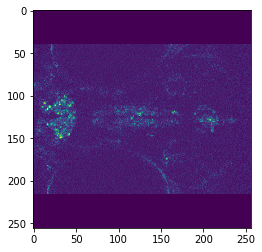

In [6]:
plt.imshow(imaging[0,0])

In [7]:
shocks = T.from_numpy(np.zeros(nT).astype(np.float32))
tail_movements = T.from_numpy(np.zeros(nT).astype(np.float32))

In [8]:
gc.collect()

28

In [9]:
# tvt_split = train_valid_test_split(2826, nchunks=20)
tvt_split = train_test_split(nT, nchunks=20)
total_examples = sum([len(x) for x in tvt_split.values()])
print(["{}: {} ({:.2f}%)".format(k, len(v), 100*len(v)/total_examples) for k,v in tvt_split.items()])


# LOAD TIFF
train_data = ZebraFishData(imaging,shocks,tail_movements,
                        tvt_split['train'], prev_frames,next_frames)

# valid_data = ZebraFishData(imaging,shocks,tail_movements,
#                         tvt_split['validation'], prev_frames,next_frames)

test_data = ZebraFishData(imaging,shocks,tail_movements,
                        tvt_split['test'], prev_frames,next_frames)

# all_data = ZebraFishData(imaging,shocks,tail_movements,None,
#                         prev_frames,next_frames)

_, nZ, H, W = train_data[0][0]["brain"].shape


# print("Number of tail movements in test: {}".format(np.array([float(x[1]["tail_movement"]) for x in test_data]).sum()))


# print("len(train_data): {}".format(len(train_data)))

# print("len(test_data): {}".format(len(test_data)))

['test: 200 (3.95%)', 'train: 4868 (96.05%)', 'validation: 0 (0.00%)']


In [10]:
del imaging

In [11]:
gc.collect()

0

In [12]:
from __future__ import print_function, division
import torch as T
import torch.nn as nn
import torch.nn.functional as F
from volume import Vol2D
from resnet import ResNet, BasicBlock
from super_res import SuperResSkip
from torch.utils.data import DataLoader, Dataset
from misc import sigmoid_schedule
from tqdm import tqdm



class DeepSkip(Vol2D):
    def __init__(self, nZ=11, H=232, W=512, nEmbedding=20, prev_frames=1, next_frames=1,
                 pred_hidden=20, tensor=T.cuda.FloatTensor):
        super(DeepSkip, self).__init__(tensor)
        self.tensor = tensor
        self.nZ = nZ
        self.H = H
        self.W = W
        self.lowH = 16
        self.lowW = 16
        self.lowFeatures = 1
        self.prev_frames = prev_frames
        # batch x channel x Z x H x W
        # Encoding
        self.resnet = ResNet(BasicBlock, [2, 2, 2, 2], prev_frames)
        self.resOut = 64
        self.nEmbedding = nEmbedding
        assert nEmbedding % 2 == 0

        # b x 11 x 32 x 11 x 25
        self.encoding_mean = nn.Linear(self.resOut*self.nZ, nEmbedding)
        self.encoding_logvar = nn.Linear(self.resOut*self.nZ, nEmbedding)
        self.nhalf_embed = int(self.nEmbedding/2)
        # Prediction
        self.pred1 = nn.Linear(self.nhalf_embed+next_frames, pred_hidden) # add dim for shock_{t+1}
        self.pred2 = nn.Linear(pred_hidden, self.nhalf_embed) # last 10 (context) are unused

        # Prediction
        self.predz1 = nn.Linear(self.nhalf_embed+next_frames, pred_hidden) # add dim for shock_{t+1}
        self.predz2 = nn.Linear(pred_hidden, self.nhalf_embed) # last 10 (context) are unused

        # Decoding
        self.activation = nn.Tanh()
        # only use 10 embeddings for frame decoding, the other 10 are context
        self.decoding = nn.Linear(self.nhalf_embed,self.lowFeatures*nZ*self.lowH*self.lowW)
        self.upconv1 = SuperResSkip(2,65,tensor)
        # 11 x 16 x 32
        self.upconv2 = SuperResSkip(2,65,tensor)
        # 11 x 32 x 64
        self.upconv3 = SuperResSkip(2,65,tensor)
        # 11 x 64 x 128
        self.upconv4 = SuperResSkip(2,65,tensor)
        # 11 x 128 x 256
#         self.upconv5 = SuperResSkip(2,tensor)
        # 11 x 256 x 512

        self.tail_decoding = nn.Linear(1,1)

        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.xavier_normal_(self.encoding_mean.weight)
        # TODO - make larger?
        nn.init.xavier_normal_(self.encoding_logvar.weight,1e-3)

    def sample_embedding(self, mu, logvar):
        if self.training:
            std = T.exp(0.5*logvar)
            eps = T.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encode(self, x):
        x = x.transpose(1,2)
        # X :: b x z x t x h x w
        out = self.tensor(x.shape[0],x.shape[1],self.resOut)
        layers = ["conv1_out", "layer1_out", "layer2_out", "layer3_out", "layer4_out"]
        layer_outputs = {k: [] for k in layers}
        for z in range(x.shape[1]):
            out[:,z], layer_out = self.resnet(x[:,z])
            for k in layers:
#                 print("layer_out "+k+" shape: "+ str(layer_out[k].shape))
                layer_outputs[k].append(layer_out[k])
        layer_outputs = {k: T.stack(v,1) for k,v in layer_outputs.items()}
        mean = self.encoding_mean(out.reshape(x.shape[0],-1))
        logvar = self.encoding_logvar(out.reshape(x.shape[0],-1))
        return mean, logvar, layer_outputs

    def predict(self, x, shock):
        x = T.cat([x, shock],1)
        x = self.activation(self.pred1(x))
        x = self.pred2(x)
        return x

    def predictZero(self, x, shock):
        x = T.cat([x, shock],1)
        x = self.activation(self.predz1(x))
        x = self.predz2(x)
        return x

    def decode(self, x, layer_output):
        tail = T.sigmoid(self.tail_decoding(x[:,[0]])) # use first embedding only
#         tail = F.sigmoid(self.tail_decoding(x[:,[0]])) # use first embedding only
        # b x 10
        # only use first half for brain data
        x = self.activation(self.decoding(x[:,:int(self.nEmbedding/2)]))
        x = x.reshape(x.shape[0],self.nZ,self.lowFeatures,self.lowH,self.lowW)
#         print("upconv1", x.shape)
        x = self.upconv1(x, layer_output["layer3_out"])
#         print("upconv2", x.shape)
        x = self.upconv2(x, layer_output["layer2_out"])
#         print("upconv3", x.shape)
        x = self.upconv3(x, layer_output["layer1_out"])
#         print("upconv4", x.shape)
        x = self.upconv4(x, layer_output["conv1_out"])
#         x = self.upconv5(x)
        x = self.crop(x[:,:,0])
        # squeeze channel
        return x, tail

    def forward(self, x, shock):
        "Return Previous volume (denoised), next volume (prediction), latent mean and logvar."
        mean, logvar, layer_outputs = self.encode(x)
        encoded = self.sample_embedding(mean, logvar)
        encoded_prev = self.predictZero(encoded[:,self.nhalf_embed:], shock)
        encoded_pred = self.predict(encoded[:,:self.nhalf_embed], shock)
        prev = self.decode(encoded_prev, layer_outputs) # force to use only skip connections for decode
        pred = self.decode(encoded_pred, layer_outputs)
        return prev, pred, mean, logvar # should we move variational layer? or return encoded_pred?

def unit_norm_KL_divergence(mu, logvar):
    "Reconstruction + KL divergence losses summed over all elements and batch."
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    return -0.5 * T.sum(1 + logvar - mu.pow(2) - logvar.exp())


def train(model,train_data,valid_data, nepochs=10, lr=1e-3, kl_lambda=1, kl_tail=1e2, half=False, cuda=True, batch_size=16, num_workers=8):
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    kl_schedule = T.from_numpy(sigmoid_schedule(nepochs))
    if half:
        optimizer = apex.fp16_utils.FP16_Optimizer(T.optim.Adam(model.parameters(),lr=lr))
    else:
        optimizer = T.optim.Adam(model.parameters(),lr=lr)

    if cuda:
        kl_schedule = kl_schedule.cuda()
    for e in range(nepochs):
        print("epoch {}: ".format(e), end="")
        cum_loss = 0
        cum_X_loss = 0
        cum_Y_loss = 0
        cum_kld_loss = 0
        cum_tail_loss = 0
        i = 0
        for batch_data in tqdm(dataloader):
            X, Y = batch_data
            X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
            Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
            if cuda:
                X = X.cuda()
                Y = Y.cuda()
                X_shock = X_shock.cuda()
                Y_shock = Y_shock.cuda()
                X_tail = X_tail.cuda()
                Y_tail = Y_tail.cuda()
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(X, Y_shock)
            if half:
                X_pred = X_pred.float()
                Y_pred = Y_pred.float()
                mean = mean.float()
                logvar = logvar.float()
            kld = unit_norm_KL_divergence(mean, logvar)
            mse_X = F.mse_loss(X_pred, Y[:,0])
            mse_Y = F.mse_loss(Y_pred, Y[:,-1])
            mse_tail = F.mse_loss(Y_pred_tail, Y_tail[:,[-1]])
            loss = mse_X + mse_Y + kl_lambda*kl_schedule[e] * kld + kl_tail*mse_tail
            if e==0:
                print("MSE_X: {:.3E}, MSE_Y: {:.3E}, KLD: {:.3E}, Tail: {:.3E}".format(float(mse_X),float(mse_Y),float(kld),float(mse_tail)))
            optimizer.zero_grad()
            if half:
                optimizer.backward(loss)
            else:
                loss.backward()
            optimizer.step()
            cum_loss += float(loss)
            cum_X_loss += float(mse_X)
            cum_Y_loss += float(mse_Y)
            cum_kld_loss += float(kld)
            cum_tail_loss += float(mse_tail)

        avg_Y_loss = cum_Y_loss/len(train_data)
        print("avg_loss: {:3E}, X_loss: {:3E}, Y_loss: {:3E}, KLD: {:3E}, tail_loss: {:3E}".format(
            cum_loss/len(train_data), cum_X_loss/len(train_data), avg_Y_loss, cum_kld_loss/len(train_data), cum_tail_loss/len(train_data)))
#         cum_loss = 0
#         cum_X_loss = 0
#         cum_Y_loss = 0
#         cum_kld_loss = 0
#         cum_tail_loss = 0
#         model.eval()
#         gc.collect()
#         for batch_data in valid_dataloader:
#             X, Y = batch_data
#             X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
#             Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
#             if cuda:
#                 X = X.cuda()
#                 Y = Y.cuda()
#                 X_shock = X_shock.cuda()
#                 Y_shock = Y_shock.cuda()
#                 X_tail = X_tail.cuda()
#                 Y_tail = Y_tail.cuda()
#             (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(X, Y_shock)
#             if half:
#                 X_pred = X_pred.float()
#                 Y_pred = Y_pred.float()
#                 mean = mean.float()
#                 logvar = logvar.float()
#             kld = unit_norm_KL_divergence(mean, logvar)
#             mse_X = F.mse_loss(X_pred, Y[:,0])
#             mse_Y = F.mse_loss(Y_pred, Y[:,-1])
#             mse_tail = F.mse_loss(X_pred_tail, X_tail[:,[-1]])
#             loss = mse_X + mse_Y + kl_lambda*kl_schedule[e] * kld + kl_tail*mse_tail
#             cum_loss += float(loss)
#             cum_X_loss += float(mse_X)
#             cum_Y_loss += float(mse_Y)
#             cum_kld_loss += float(kld)
#             cum_tail_loss += float(mse_tail)
#         model.train()
#         avg_Y_valid_loss = cum_Y_loss/len(valid_data)
#         print("VALIDATION: avg_loss: {:3E}, X_loss: {:3E}, Y_loss: {:3E}, KLD: {:3E}, tail_loss: {:3E}".format(
#             cum_loss/len(valid_data), cum_X_loss/len(valid_data), avg_Y_valid_loss, cum_kld_loss/len(valid_data), cum_tail_loss/len(valid_data)))
    return avg_Y_loss, avg_Y_valid_loss


In [13]:
batch_size = 12
multi_gpu = True

tensorlib = T
if cuda:
    tensorlib = T.cuda

if half:
    tensor = tensorlib.HalfTensor
else:
    tensor = tensorlib.FloatTensor

conv_model = DeepSkip(nZ,H,W,nEmbedding,prev_frames,next_frames, tensor=tensor)
if cuda:
    conv_model.cuda()
if half:
    conv_model = apex.fp16_utils.network_to_half(conv_model)
if multi_gpu:
    conv_model = nn.DataParallel(conv_model)
print("total num params:", np.sum([np.prod(x.shape) for x in conv_model.parameters()]))
# conv_model(data[0][0][None,:,None].cuda()).shape


# WARNING: TEST DATA BEING USED
avg_Y_loss, avg_Y_valid_loss = train(conv_model,train_data,test_data,nepochs,lr=lr, kl_lambda=1e-3, half=half, cuda=cuda, batch_size=batch_size, num_workers=num_workers)

now = datetime.datetime.today().strftime('%y%m%d-%I:%M%p')

model_name = "/data2/trained_models/{}_{}_{}_X=t-4:t_Y=t+1,t+5_epochs={}".format(now, f.fishid, model, nepochs) +     "_Y_MSE={:.3E}_Y_val_MSE={:.3E}".format(avg_Y_loss, avg_Y_valid_loss)


T.save(conv_model.state_dict(),model_name+".pt")
print("Saved "+model_name+".pt")

frame = makePredVideo(conv_model,train_data,name=model_name+'_train')
makePredVideo(conv_model,train_data,name=model_name+'_test')

  0%|          | 0/406 [00:00<?, ?it/s]

total num params: 1420430
epoch 0: MSE_X: 1.705E+03, MSE_Y: 1.730E+03, KLD: 6.167E+01, Tail: 7.626E-02


  0%|          | 1/406 [00:25<2:52:12, 25.51s/it]

MSE_X: 1.656E+03, MSE_Y: 1.697E+03, KLD: 3.139E+02, Tail: 4.956E-02


  0%|          | 2/406 [00:33<1:51:18, 16.53s/it]

MSE_X: 1.548E+03, MSE_Y: 1.554E+03, KLD: 6.156E+02, Tail: 3.844E-02


  1%|          | 3/406 [00:37<1:22:50, 12.33s/it]

MSE_X: 1.579E+03, MSE_Y: 1.619E+03, KLD: 1.065E+03, Tail: 3.388E-02


  1%|          | 4/406 [00:40<1:08:21, 10.20s/it]

MSE_X: 1.788E+03, MSE_Y: 1.795E+03, KLD: 1.597E+03, Tail: 3.043E-02


  1%|          | 5/406 [00:44<59:29,  8.90s/it]  

MSE_X: 1.653E+03, MSE_Y: 1.685E+03, KLD: 2.195E+03, Tail: 2.761E-02


  1%|▏         | 6/406 [00:48<53:35,  8.04s/it]

MSE_X: 1.448E+03, MSE_Y: 1.482E+03, KLD: 2.867E+03, Tail: 2.557E-02


  2%|▏         | 7/406 [00:51<49:11,  7.40s/it]

MSE_X: 1.689E+03, MSE_Y: 1.665E+03, KLD: 3.558E+03, Tail: 2.408E-02


  2%|▏         | 8/406 [00:55<46:00,  6.94s/it]

MSE_X: 1.548E+03, MSE_Y: 1.584E+03, KLD: 4.281E+03, Tail: 2.241E-02


  2%|▏         | 9/406 [00:59<43:24,  6.56s/it]

MSE_X: 1.525E+03, MSE_Y: 1.675E+03, KLD: 4.994E+03, Tail: 2.109E-02


  2%|▏         | 10/406 [01:02<41:25,  6.28s/it]

MSE_X: 1.730E+03, MSE_Y: 1.752E+03, KLD: 5.673E+03, Tail: 2.017E-02


  3%|▎         | 11/406 [01:06<39:46,  6.04s/it]

MSE_X: 1.611E+03, MSE_Y: 1.603E+03, KLD: 6.382E+03, Tail: 1.941E-02


  3%|▎         | 12/406 [01:10<38:24,  5.85s/it]

MSE_X: 1.612E+03, MSE_Y: 1.625E+03, KLD: 7.037E+03, Tail: 1.880E-02


  3%|▎         | 13/406 [01:13<37:14,  5.68s/it]

MSE_X: 1.524E+03, MSE_Y: 1.533E+03, KLD: 7.711E+03, Tail: 1.828E-02


  3%|▎         | 14/406 [01:17<36:14,  5.55s/it]

MSE_X: 1.697E+03, MSE_Y: 1.674E+03, KLD: 8.307E+03, Tail: 1.783E-02


  4%|▎         | 15/406 [01:21<35:21,  5.42s/it]

MSE_X: 1.583E+03, MSE_Y: 1.611E+03, KLD: 8.843E+03, Tail: 1.740E-02


  4%|▍         | 16/406 [01:25<34:33,  5.32s/it]

MSE_X: 1.521E+03, MSE_Y: 1.570E+03, KLD: 9.324E+03, Tail: 1.701E-02


  4%|▍         | 17/406 [01:28<33:48,  5.21s/it]

MSE_X: 1.939E+03, MSE_Y: 1.967E+03, KLD: 9.802E+03, Tail: 1.664E-02


  4%|▍         | 18/406 [01:32<33:09,  5.13s/it]

MSE_X: 1.523E+03, MSE_Y: 1.572E+03, KLD: 1.025E+04, Tail: 1.628E-02


  5%|▍         | 19/406 [01:36<32:36,  5.06s/it]

MSE_X: 1.564E+03, MSE_Y: 1.589E+03, KLD: 1.065E+04, Tail: 1.593E-02


  5%|▍         | 20/406 [01:39<32:03,  4.98s/it]

MSE_X: 1.490E+03, MSE_Y: 1.539E+03, KLD: 1.098E+04, Tail: 1.558E-02


  5%|▌         | 21/406 [01:43<31:35,  4.92s/it]

MSE_X: 1.503E+03, MSE_Y: 1.543E+03, KLD: 1.126E+04, Tail: 1.525E-02


  5%|▌         | 22/406 [01:47<31:09,  4.87s/it]

MSE_X: 1.608E+03, MSE_Y: 1.711E+03, KLD: 1.152E+04, Tail: 1.493E-02


  6%|▌         | 23/406 [01:50<30:46,  4.82s/it]

MSE_X: 1.549E+03, MSE_Y: 1.538E+03, KLD: 1.172E+04, Tail: 1.461E-02


  6%|▌         | 24/406 [01:54<30:24,  4.78s/it]

MSE_X: 1.489E+03, MSE_Y: 1.588E+03, KLD: 1.189E+04, Tail: 1.430E-02


  6%|▌         | 25/406 [01:58<30:03,  4.73s/it]

MSE_X: 1.534E+03, MSE_Y: 1.538E+03, KLD: 1.201E+04, Tail: 1.399E-02


  6%|▋         | 26/406 [02:01<29:41,  4.69s/it]

MSE_X: 1.447E+03, MSE_Y: 1.479E+03, KLD: 1.207E+04, Tail: 1.370E-02


  7%|▋         | 27/406 [02:05<29:22,  4.65s/it]

MSE_X: 1.575E+03, MSE_Y: 1.570E+03, KLD: 1.217E+04, Tail: 1.341E-02


  7%|▋         | 28/406 [02:09<29:04,  4.62s/it]

MSE_X: 1.573E+03, MSE_Y: 1.643E+03, KLD: 1.220E+04, Tail: 1.313E-02


  7%|▋         | 29/406 [02:12<28:46,  4.58s/it]

MSE_X: 1.544E+03, MSE_Y: 1.562E+03, KLD: 1.220E+04, Tail: 1.286E-02


  7%|▋         | 30/406 [02:16<28:30,  4.55s/it]

MSE_X: 1.532E+03, MSE_Y: 1.563E+03, KLD: 1.212E+04, Tail: 1.259E-02


  8%|▊         | 31/406 [02:20<28:14,  4.52s/it]

MSE_X: 1.461E+03, MSE_Y: 1.490E+03, KLD: 1.203E+04, Tail: 1.233E-02


  8%|▊         | 32/406 [02:23<28:01,  4.49s/it]

MSE_X: 1.501E+03, MSE_Y: 1.550E+03, KLD: 1.198E+04, Tail: 1.207E-02


  8%|▊         | 33/406 [02:27<27:48,  4.47s/it]

MSE_X: 1.581E+03, MSE_Y: 1.580E+03, KLD: 1.190E+04, Tail: 1.183E-02


  8%|▊         | 34/406 [02:31<27:35,  4.45s/it]

MSE_X: 1.628E+03, MSE_Y: 1.644E+03, KLD: 1.174E+04, Tail: 1.158E-02


  9%|▊         | 35/406 [02:34<27:22,  4.43s/it]

MSE_X: 1.599E+03, MSE_Y: 1.606E+03, KLD: 1.158E+04, Tail: 1.135E-02


  9%|▉         | 36/406 [02:38<27:10,  4.41s/it]

MSE_X: 1.562E+03, MSE_Y: 1.602E+03, KLD: 1.145E+04, Tail: 1.112E-02


  9%|▉         | 37/406 [02:42<26:58,  4.39s/it]

MSE_X: 1.528E+03, MSE_Y: 1.527E+03, KLD: 1.130E+04, Tail: 1.089E-02


  9%|▉         | 38/406 [02:46<26:47,  4.37s/it]

MSE_X: 1.580E+03, MSE_Y: 1.561E+03, KLD: 1.117E+04, Tail: 1.068E-02


 10%|▉         | 39/406 [02:49<26:36,  4.35s/it]

MSE_X: 1.489E+03, MSE_Y: 1.563E+03, KLD: 1.098E+04, Tail: 1.046E-02


 10%|▉         | 40/406 [02:53<26:25,  4.33s/it]

MSE_X: 1.625E+03, MSE_Y: 1.708E+03, KLD: 1.079E+04, Tail: 1.025E-02


 10%|█         | 41/406 [02:56<26:15,  4.32s/it]

MSE_X: 1.643E+03, MSE_Y: 1.696E+03, KLD: 1.062E+04, Tail: 1.005E-02


 10%|█         | 42/406 [03:00<26:05,  4.30s/it]

MSE_X: 1.488E+03, MSE_Y: 1.510E+03, KLD: 1.045E+04, Tail: 9.853E-03


 11%|█         | 43/406 [03:04<25:56,  4.29s/it]

MSE_X: 1.530E+03, MSE_Y: 1.531E+03, KLD: 1.024E+04, Tail: 9.661E-03


 11%|█         | 44/406 [03:07<25:45,  4.27s/it]

MSE_X: 1.631E+03, MSE_Y: 1.649E+03, KLD: 1.003E+04, Tail: 9.474E-03


 11%|█         | 45/406 [03:11<25:36,  4.26s/it]

MSE_X: 1.445E+03, MSE_Y: 1.492E+03, KLD: 9.842E+03, Tail: 9.290E-03


 11%|█▏        | 46/406 [03:15<25:28,  4.25s/it]

MSE_X: 1.418E+03, MSE_Y: 1.451E+03, KLD: 9.614E+03, Tail: 9.111E-03


 12%|█▏        | 47/406 [03:18<25:19,  4.23s/it]

MSE_X: 1.548E+03, MSE_Y: 1.573E+03, KLD: 9.445E+03, Tail: 8.938E-03


 12%|█▏        | 48/406 [03:22<25:10,  4.22s/it]

MSE_X: 1.517E+03, MSE_Y: 1.579E+03, KLD: 9.239E+03, Tail: 8.768E-03


 12%|█▏        | 49/406 [03:26<25:02,  4.21s/it]

MSE_X: 1.538E+03, MSE_Y: 1.526E+03, KLD: 9.085E+03, Tail: 8.602E-03


 12%|█▏        | 50/406 [03:29<24:54,  4.20s/it]

MSE_X: 1.417E+03, MSE_Y: 1.453E+03, KLD: 8.896E+03, Tail: 8.440E-03


 13%|█▎        | 51/406 [03:33<24:46,  4.19s/it]

MSE_X: 1.519E+03, MSE_Y: 1.562E+03, KLD: 8.725E+03, Tail: 8.284E-03


 13%|█▎        | 52/406 [03:37<24:38,  4.18s/it]

MSE_X: 1.403E+03, MSE_Y: 1.455E+03, KLD: 8.541E+03, Tail: 8.129E-03


 13%|█▎        | 53/406 [03:40<24:30,  4.17s/it]

MSE_X: 1.518E+03, MSE_Y: 1.570E+03, KLD: 8.386E+03, Tail: 7.980E-03


 13%|█▎        | 54/406 [03:44<24:23,  4.16s/it]

MSE_X: 1.435E+03, MSE_Y: 1.624E+03, KLD: 8.190E+03, Tail: 7.834E-03


 14%|█▎        | 55/406 [03:48<24:16,  4.15s/it]

MSE_X: 1.457E+03, MSE_Y: 1.498E+03, KLD: 8.044E+03, Tail: 7.692E-03


 14%|█▍        | 56/406 [03:51<24:09,  4.14s/it]

MSE_X: 1.354E+03, MSE_Y: 1.504E+03, KLD: 7.900E+03, Tail: 7.554E-03


 14%|█▍        | 57/406 [03:55<24:02,  4.13s/it]

MSE_X: 1.387E+03, MSE_Y: 1.421E+03, KLD: 7.759E+03, Tail: 7.418E-03


 14%|█▍        | 58/406 [03:59<23:55,  4.12s/it]

MSE_X: 1.568E+03, MSE_Y: 1.559E+03, KLD: 7.538E+03, Tail: 7.287E-03


 15%|█▍        | 59/406 [04:02<23:48,  4.12s/it]

MSE_X: 1.384E+03, MSE_Y: 1.408E+03, KLD: 7.465E+03, Tail: 7.159E-03


 15%|█▍        | 60/406 [04:06<23:41,  4.11s/it]

MSE_X: 1.455E+03, MSE_Y: 1.446E+03, KLD: 7.305E+03, Tail: 7.033E-03


 15%|█▌        | 61/406 [04:10<23:34,  4.10s/it]

MSE_X: 1.532E+03, MSE_Y: 1.535E+03, KLD: 7.194E+03, Tail: 6.909E-03


 15%|█▌        | 62/406 [04:13<23:28,  4.09s/it]

MSE_X: 1.469E+03, MSE_Y: 1.495E+03, KLD: 7.103E+03, Tail: 6.788E-03


 16%|█▌        | 63/406 [04:17<23:21,  4.09s/it]

MSE_X: 1.464E+03, MSE_Y: 1.543E+03, KLD: 6.932E+03, Tail: 6.672E-03


 16%|█▌        | 64/406 [04:21<23:15,  4.08s/it]

MSE_X: 1.406E+03, MSE_Y: 1.459E+03, KLD: 6.842E+03, Tail: 6.558E-03


 16%|█▌        | 65/406 [04:24<23:09,  4.07s/it]

MSE_X: 1.410E+03, MSE_Y: 1.406E+03, KLD: 6.741E+03, Tail: 6.445E-03


 16%|█▋        | 66/406 [04:28<23:03,  4.07s/it]

MSE_X: 1.456E+03, MSE_Y: 1.527E+03, KLD: 6.598E+03, Tail: 6.339E-03


 17%|█▋        | 67/406 [04:32<22:57,  4.06s/it]

MSE_X: 1.395E+03, MSE_Y: 1.442E+03, KLD: 6.462E+03, Tail: 6.233E-03


 17%|█▋        | 68/406 [04:35<22:50,  4.06s/it]

MSE_X: 1.385E+03, MSE_Y: 1.471E+03, KLD: 6.340E+03, Tail: 6.130E-03


 17%|█▋        | 69/406 [04:39<22:44,  4.05s/it]

MSE_X: 1.414E+03, MSE_Y: 1.409E+03, KLD: 6.271E+03, Tail: 6.033E-03


 17%|█▋        | 70/406 [04:43<22:38,  4.04s/it]

MSE_X: 1.463E+03, MSE_Y: 1.481E+03, KLD: 6.188E+03, Tail: 5.929E-03


 17%|█▋        | 71/406 [04:46<22:33,  4.04s/it]

MSE_X: 1.409E+03, MSE_Y: 1.469E+03, KLD: 6.139E+03, Tail: 5.831E-03


 18%|█▊        | 72/406 [04:50<22:27,  4.03s/it]

MSE_X: 1.536E+03, MSE_Y: 1.549E+03, KLD: 6.061E+03, Tail: 5.738E-03


 18%|█▊        | 73/406 [04:54<22:21,  4.03s/it]

MSE_X: 1.569E+03, MSE_Y: 1.553E+03, KLD: 5.983E+03, Tail: 5.646E-03


 18%|█▊        | 74/406 [04:57<22:16,  4.02s/it]

MSE_X: 1.507E+03, MSE_Y: 1.561E+03, KLD: 5.947E+03, Tail: 5.554E-03


 18%|█▊        | 75/406 [05:01<22:10,  4.02s/it]

MSE_X: 1.355E+03, MSE_Y: 1.441E+03, KLD: 5.820E+03, Tail: 5.468E-03


 19%|█▊        | 76/406 [05:04<22:04,  4.01s/it]

MSE_X: 1.420E+03, MSE_Y: 1.486E+03, KLD: 5.830E+03, Tail: 5.378E-03


 19%|█▉        | 77/406 [05:08<21:58,  4.01s/it]

MSE_X: 1.473E+03, MSE_Y: 1.526E+03, KLD: 5.727E+03, Tail: 5.295E-03


 19%|█▉        | 78/406 [05:12<21:52,  4.00s/it]

MSE_X: 1.301E+03, MSE_Y: 1.339E+03, KLD: 5.725E+03, Tail: 5.210E-03


 19%|█▉        | 79/406 [05:15<21:46,  4.00s/it]

MSE_X: 1.465E+03, MSE_Y: 1.489E+03, KLD: 5.747E+03, Tail: 5.129E-03


 20%|█▉        | 80/406 [05:19<21:41,  3.99s/it]

MSE_X: 1.376E+03, MSE_Y: 1.514E+03, KLD: 5.801E+03, Tail: 5.046E-03


 20%|█▉        | 81/406 [05:23<21:36,  3.99s/it]

MSE_X: 1.449E+03, MSE_Y: 1.494E+03, KLD: 5.798E+03, Tail: 4.968E-03


 20%|██        | 82/406 [05:26<21:31,  3.99s/it]

MSE_X: 1.448E+03, MSE_Y: 1.454E+03, KLD: 5.861E+03, Tail: 4.889E-03


 20%|██        | 83/406 [05:30<21:26,  3.98s/it]

MSE_X: 1.499E+03, MSE_Y: 1.523E+03, KLD: 5.874E+03, Tail: 4.814E-03


 21%|██        | 84/406 [05:34<21:21,  3.98s/it]

MSE_X: 1.572E+03, MSE_Y: 1.580E+03, KLD: 5.815E+03, Tail: 4.741E-03


 21%|██        | 85/406 [05:37<21:15,  3.97s/it]

MSE_X: 1.422E+03, MSE_Y: 1.460E+03, KLD: 5.638E+03, Tail: 4.674E-03


 21%|██        | 86/406 [05:41<21:10,  3.97s/it]

MSE_X: 1.353E+03, MSE_Y: 1.363E+03, KLD: 5.582E+03, Tail: 4.605E-03


 21%|██▏       | 87/406 [05:45<21:05,  3.97s/it]

MSE_X: 1.471E+03, MSE_Y: 1.527E+03, KLD: 5.500E+03, Tail: 4.538E-03


 22%|██▏       | 88/406 [05:48<21:00,  3.96s/it]

MSE_X: 1.468E+03, MSE_Y: 1.526E+03, KLD: 5.399E+03, Tail: 4.473E-03


 22%|██▏       | 89/406 [05:52<20:55,  3.96s/it]

MSE_X: 1.363E+03, MSE_Y: 1.423E+03, KLD: 5.320E+03, Tail: 4.408E-03


 22%|██▏       | 90/406 [05:56<20:50,  3.96s/it]

MSE_X: 1.504E+03, MSE_Y: 1.536E+03, KLD: 5.213E+03, Tail: 4.348E-03


 22%|██▏       | 91/406 [05:59<20:45,  3.95s/it]

MSE_X: 1.396E+03, MSE_Y: 1.443E+03, KLD: 5.097E+03, Tail: 4.287E-03


 23%|██▎       | 92/406 [06:03<20:40,  3.95s/it]

MSE_X: 1.327E+03, MSE_Y: 1.401E+03, KLD: 5.047E+03, Tail: 4.226E-03


 23%|██▎       | 93/406 [06:07<20:35,  3.95s/it]

MSE_X: 1.456E+03, MSE_Y: 1.441E+03, KLD: 5.002E+03, Tail: 4.168E-03


 23%|██▎       | 94/406 [06:10<20:29,  3.94s/it]

MSE_X: 1.365E+03, MSE_Y: 1.452E+03, KLD: 4.946E+03, Tail: 4.110E-03


 23%|██▎       | 95/406 [06:14<20:24,  3.94s/it]

MSE_X: 1.366E+03, MSE_Y: 1.447E+03, KLD: 4.908E+03, Tail: 4.053E-03


 24%|██▎       | 96/406 [06:17<20:20,  3.94s/it]

MSE_X: 1.317E+03, MSE_Y: 1.388E+03, KLD: 4.925E+03, Tail: 3.994E-03


 24%|██▍       | 97/406 [06:21<20:15,  3.93s/it]

MSE_X: 1.401E+03, MSE_Y: 1.482E+03, KLD: 4.828E+03, Tail: 3.942E-03


 24%|██▍       | 98/406 [06:25<20:10,  3.93s/it]

MSE_X: 1.383E+03, MSE_Y: 1.488E+03, KLD: 4.792E+03, Tail: 3.886E-03


 24%|██▍       | 99/406 [06:28<20:06,  3.93s/it]

MSE_X: 1.252E+03, MSE_Y: 1.328E+03, KLD: 4.744E+03, Tail: 3.834E-03


 25%|██▍       | 100/406 [06:32<20:01,  3.93s/it]

MSE_X: 1.394E+03, MSE_Y: 1.486E+03, KLD: 4.724E+03, Tail: 3.782E-03


 25%|██▍       | 101/406 [06:36<19:56,  3.92s/it]

MSE_X: 1.320E+03, MSE_Y: 1.398E+03, KLD: 4.625E+03, Tail: 3.734E-03


 25%|██▌       | 102/406 [06:39<19:51,  3.92s/it]

MSE_X: 1.341E+03, MSE_Y: 1.427E+03, KLD: 4.742E+03, Tail: 3.679E-03


 25%|██▌       | 103/406 [06:43<19:47,  3.92s/it]

MSE_X: 1.356E+03, MSE_Y: 1.414E+03, KLD: 4.766E+03, Tail: 3.630E-03


 26%|██▌       | 104/406 [06:47<19:42,  3.92s/it]

MSE_X: 1.347E+03, MSE_Y: 1.400E+03, KLD: 4.786E+03, Tail: 3.581E-03


 26%|██▌       | 105/406 [06:50<19:38,  3.91s/it]

MSE_X: 1.329E+03, MSE_Y: 1.423E+03, KLD: 4.722E+03, Tail: 3.535E-03


 26%|██▌       | 106/406 [06:54<19:33,  3.91s/it]

MSE_X: 1.322E+03, MSE_Y: 1.377E+03, KLD: 4.697E+03, Tail: 3.488E-03


 26%|██▋       | 107/406 [06:58<19:28,  3.91s/it]

MSE_X: 1.377E+03, MSE_Y: 1.413E+03, KLD: 4.610E+03, Tail: 3.445E-03


 27%|██▋       | 108/406 [07:01<19:23,  3.91s/it]

MSE_X: 1.409E+03, MSE_Y: 1.507E+03, KLD: 4.647E+03, Tail: 3.398E-03


 27%|██▋       | 109/406 [07:05<19:19,  3.90s/it]

MSE_X: 1.452E+03, MSE_Y: 1.492E+03, KLD: 4.650E+03, Tail: 3.353E-03


 27%|██▋       | 110/406 [07:09<19:14,  3.90s/it]

MSE_X: 1.322E+03, MSE_Y: 1.395E+03, KLD: 4.585E+03, Tail: 3.311E-03


 27%|██▋       | 111/406 [07:13<19:10,  3.90s/it]

MSE_X: 1.405E+03, MSE_Y: 1.434E+03, KLD: 4.562E+03, Tail: 3.270E-03


 28%|██▊       | 112/406 [07:16<19:06,  3.90s/it]

MSE_X: 1.326E+03, MSE_Y: 1.410E+03, KLD: 4.551E+03, Tail: 3.229E-03


 28%|██▊       | 113/406 [07:20<19:01,  3.90s/it]

MSE_X: 1.327E+03, MSE_Y: 1.390E+03, KLD: 4.523E+03, Tail: 3.190E-03


 28%|██▊       | 114/406 [07:24<18:57,  3.90s/it]

MSE_X: 1.422E+03, MSE_Y: 1.484E+03, KLD: 4.531E+03, Tail: 3.148E-03


 28%|██▊       | 115/406 [07:27<18:52,  3.89s/it]

MSE_X: 1.400E+03, MSE_Y: 1.472E+03, KLD: 4.446E+03, Tail: 3.112E-03


 29%|██▊       | 116/406 [07:31<18:48,  3.89s/it]

MSE_X: 1.302E+03, MSE_Y: 1.372E+03, KLD: 4.449E+03, Tail: 3.072E-03


 29%|██▉       | 117/406 [07:35<18:44,  3.89s/it]

MSE_X: 1.436E+03, MSE_Y: 1.513E+03, KLD: 4.401E+03, Tail: 3.036E-03


 29%|██▉       | 118/406 [07:38<18:39,  3.89s/it]

MSE_X: 1.317E+03, MSE_Y: 1.444E+03, KLD: 4.340E+03, Tail: 3.000E-03


 29%|██▉       | 119/406 [07:42<18:35,  3.89s/it]

MSE_X: 1.354E+03, MSE_Y: 1.488E+03, KLD: 4.360E+03, Tail: 2.967E-03


 30%|██▉       | 120/406 [07:46<18:30,  3.88s/it]

MSE_X: 1.519E+03, MSE_Y: 1.592E+03, KLD: 4.424E+03, Tail: 2.930E-03


 30%|██▉       | 121/406 [07:49<18:26,  3.88s/it]

MSE_X: 1.281E+03, MSE_Y: 1.369E+03, KLD: 4.525E+03, Tail: 2.893E-03


 30%|███       | 122/406 [07:53<18:22,  3.88s/it]

MSE_X: 1.400E+03, MSE_Y: 1.478E+03, KLD: 4.518E+03, Tail: 2.860E-03


 30%|███       | 123/406 [07:57<18:17,  3.88s/it]

MSE_X: 1.610E+03, MSE_Y: 1.716E+03, KLD: 4.474E+03, Tail: 2.828E-03


 31%|███       | 124/406 [08:00<18:13,  3.88s/it]

MSE_X: 1.340E+03, MSE_Y: 1.450E+03, KLD: 4.454E+03, Tail: 2.791E-03


 31%|███       | 125/406 [08:04<18:09,  3.88s/it]

MSE_X: 1.501E+03, MSE_Y: 1.559E+03, KLD: 4.399E+03, Tail: 2.758E-03


 31%|███       | 126/406 [08:08<18:04,  3.87s/it]

MSE_X: 1.355E+03, MSE_Y: 1.481E+03, KLD: 4.339E+03, Tail: 2.725E-03


 31%|███▏      | 127/406 [08:11<18:00,  3.87s/it]

MSE_X: 1.350E+03, MSE_Y: 1.448E+03, KLD: 4.364E+03, Tail: 2.691E-03


 32%|███▏      | 128/406 [08:15<17:56,  3.87s/it]

MSE_X: 1.335E+03, MSE_Y: 1.385E+03, KLD: 4.405E+03, Tail: 2.659E-03


 32%|███▏      | 129/406 [08:19<17:52,  3.87s/it]

MSE_X: 1.380E+03, MSE_Y: 1.428E+03, KLD: 4.346E+03, Tail: 2.628E-03


 32%|███▏      | 130/406 [08:23<17:48,  3.87s/it]

MSE_X: 1.274E+03, MSE_Y: 1.398E+03, KLD: 4.364E+03, Tail: 2.596E-03


 32%|███▏      | 131/406 [08:26<17:43,  3.87s/it]

MSE_X: 1.312E+03, MSE_Y: 1.418E+03, KLD: 4.263E+03, Tail: 2.568E-03


 33%|███▎      | 132/406 [08:30<17:39,  3.87s/it]

MSE_X: 1.319E+03, MSE_Y: 1.446E+03, KLD: 4.235E+03, Tail: 2.540E-03


 33%|███▎      | 133/406 [08:33<17:35,  3.86s/it]

MSE_X: 1.311E+03, MSE_Y: 1.397E+03, KLD: 4.180E+03, Tail: 2.514E-03


 33%|███▎      | 134/406 [08:37<17:30,  3.86s/it]

MSE_X: 1.470E+03, MSE_Y: 1.508E+03, KLD: 4.307E+03, Tail: 2.485E-03


 33%|███▎      | 135/406 [08:41<17:26,  3.86s/it]

MSE_X: 1.490E+03, MSE_Y: 1.552E+03, KLD: 4.503E+03, Tail: 2.457E-03


 33%|███▎      | 136/406 [08:45<17:22,  3.86s/it]

MSE_X: 1.246E+03, MSE_Y: 1.347E+03, KLD: 4.613E+03, Tail: 2.431E-03


 34%|███▎      | 137/406 [08:48<17:18,  3.86s/it]

MSE_X: 1.312E+03, MSE_Y: 1.376E+03, KLD: 4.647E+03, Tail: 2.407E-03


 34%|███▍      | 138/406 [08:52<17:14,  3.86s/it]

MSE_X: 1.320E+03, MSE_Y: 1.391E+03, KLD: 4.614E+03, Tail: 2.381E-03


 34%|███▍      | 139/406 [08:56<17:09,  3.86s/it]

MSE_X: 1.321E+03, MSE_Y: 1.415E+03, KLD: 4.523E+03, Tail: 2.355E-03


 34%|███▍      | 140/406 [08:59<17:05,  3.86s/it]

MSE_X: 1.276E+03, MSE_Y: 1.351E+03, KLD: 4.408E+03, Tail: 2.330E-03


 35%|███▍      | 141/406 [09:03<17:01,  3.85s/it]

MSE_X: 1.308E+03, MSE_Y: 1.359E+03, KLD: 4.192E+03, Tail: 2.308E-03


 35%|███▍      | 142/406 [09:07<16:57,  3.85s/it]

MSE_X: 1.304E+03, MSE_Y: 1.375E+03, KLD: 4.070E+03, Tail: 2.283E-03


 35%|███▌      | 143/406 [09:10<16:52,  3.85s/it]

MSE_X: 1.285E+03, MSE_Y: 1.493E+03, KLD: 3.941E+03, Tail: 2.259E-03


 35%|███▌      | 144/406 [09:14<16:48,  3.85s/it]

MSE_X: 1.394E+03, MSE_Y: 1.542E+03, KLD: 3.849E+03, Tail: 2.236E-03


 36%|███▌      | 145/406 [09:17<16:44,  3.85s/it]

MSE_X: 1.235E+03, MSE_Y: 1.317E+03, KLD: 3.814E+03, Tail: 2.213E-03


 36%|███▌      | 146/406 [09:21<16:39,  3.85s/it]

MSE_X: 1.361E+03, MSE_Y: 1.412E+03, KLD: 3.913E+03, Tail: 2.188E-03


 36%|███▌      | 147/406 [09:25<16:35,  3.84s/it]

MSE_X: 1.259E+03, MSE_Y: 1.364E+03, KLD: 3.921E+03, Tail: 2.167E-03


 36%|███▋      | 148/406 [09:28<16:31,  3.84s/it]

MSE_X: 1.325E+03, MSE_Y: 1.409E+03, KLD: 4.110E+03, Tail: 2.140E-03


 37%|███▋      | 149/406 [09:32<16:27,  3.84s/it]

MSE_X: 1.376E+03, MSE_Y: 1.414E+03, KLD: 4.193E+03, Tail: 2.117E-03


 37%|███▋      | 150/406 [09:36<16:23,  3.84s/it]

MSE_X: 1.366E+03, MSE_Y: 1.399E+03, KLD: 4.267E+03, Tail: 2.094E-03


 37%|███▋      | 151/406 [09:39<16:19,  3.84s/it]

MSE_X: 1.351E+03, MSE_Y: 1.376E+03, KLD: 4.328E+03, Tail: 2.069E-03


 37%|███▋      | 152/406 [09:43<16:14,  3.84s/it]

MSE_X: 1.244E+03, MSE_Y: 1.329E+03, KLD: 4.278E+03, Tail: 2.050E-03


 38%|███▊      | 153/406 [09:47<16:10,  3.84s/it]

MSE_X: 1.283E+03, MSE_Y: 1.378E+03, KLD: 4.218E+03, Tail: 2.028E-03


 38%|███▊      | 154/406 [09:50<16:06,  3.84s/it]

MSE_X: 1.408E+03, MSE_Y: 1.437E+03, KLD: 4.088E+03, Tail: 2.010E-03


 38%|███▊      | 155/406 [09:54<16:02,  3.83s/it]

MSE_X: 1.350E+03, MSE_Y: 1.418E+03, KLD: 4.087E+03, Tail: 1.990E-03


 38%|███▊      | 156/406 [09:57<15:57,  3.83s/it]

MSE_X: 1.285E+03, MSE_Y: 1.505E+03, KLD: 4.130E+03, Tail: 1.970E-03


 39%|███▊      | 157/406 [10:01<15:53,  3.83s/it]

MSE_X: 1.373E+03, MSE_Y: 1.429E+03, KLD: 4.025E+03, Tail: 1.954E-03


 39%|███▉      | 158/406 [10:04<15:49,  3.83s/it]

MSE_X: 1.356E+03, MSE_Y: 1.433E+03, KLD: 4.037E+03, Tail: 1.934E-03


 39%|███▉      | 159/406 [10:08<15:45,  3.83s/it]

MSE_X: 1.322E+03, MSE_Y: 1.379E+03, KLD: 3.961E+03, Tail: 1.917E-03


 39%|███▉      | 160/406 [10:12<15:41,  3.83s/it]

MSE_X: 1.373E+03, MSE_Y: 1.429E+03, KLD: 3.956E+03, Tail: 1.898E-03


 40%|███▉      | 161/406 [10:15<15:37,  3.83s/it]

MSE_X: 1.340E+03, MSE_Y: 1.411E+03, KLD: 3.881E+03, Tail: 1.878E-03


 40%|███▉      | 162/406 [10:19<15:33,  3.82s/it]

MSE_X: 1.221E+03, MSE_Y: 1.307E+03, KLD: 3.688E+03, Tail: 1.862E-03


 40%|████      | 163/406 [10:23<15:29,  3.82s/it]

MSE_X: 1.305E+03, MSE_Y: 1.349E+03, KLD: 3.568E+03, Tail: 1.848E-03


 40%|████      | 164/406 [10:26<15:25,  3.82s/it]

MSE_X: 1.284E+03, MSE_Y: 1.396E+03, KLD: 3.699E+03, Tail: 1.831E-03


 41%|████      | 165/406 [10:30<15:21,  3.82s/it]

MSE_X: 1.275E+03, MSE_Y: 1.379E+03, KLD: 3.963E+03, Tail: 1.813E-03


 41%|████      | 166/406 [10:34<15:16,  3.82s/it]

MSE_X: 1.356E+03, MSE_Y: 1.432E+03, KLD: 4.199E+03, Tail: 1.794E-03


 41%|████      | 167/406 [10:37<15:12,  3.82s/it]

MSE_X: 1.306E+03, MSE_Y: 1.492E+03, KLD: 4.351E+03, Tail: 1.779E-03


 41%|████▏     | 168/406 [10:41<15:08,  3.82s/it]

MSE_X: 1.305E+03, MSE_Y: 1.487E+03, KLD: 4.481E+03, Tail: 1.763E-03


 42%|████▏     | 169/406 [10:44<15:04,  3.82s/it]

MSE_X: 1.255E+03, MSE_Y: 1.338E+03, KLD: 4.619E+03, Tail: 1.744E-03


 42%|████▏     | 170/406 [10:48<15:00,  3.81s/it]

MSE_X: 1.311E+03, MSE_Y: 1.342E+03, KLD: 4.571E+03, Tail: 1.729E-03


 42%|████▏     | 171/406 [10:52<14:56,  3.81s/it]

MSE_X: 1.340E+03, MSE_Y: 1.435E+03, KLD: 4.545E+03, Tail: 1.711E-03


 42%|████▏     | 172/406 [10:55<14:51,  3.81s/it]

MSE_X: 1.298E+03, MSE_Y: 1.372E+03, KLD: 4.382E+03, Tail: 1.697E-03


 43%|████▎     | 173/406 [10:59<14:47,  3.81s/it]

MSE_X: 1.342E+03, MSE_Y: 1.416E+03, KLD: 4.279E+03, Tail: 1.678E-03


 43%|████▎     | 174/406 [11:02<14:43,  3.81s/it]

MSE_X: 1.295E+03, MSE_Y: 1.442E+03, KLD: 4.084E+03, Tail: 1.663E-03


 43%|████▎     | 175/406 [11:06<14:39,  3.81s/it]

MSE_X: 1.274E+03, MSE_Y: 1.355E+03, KLD: 3.879E+03, Tail: 1.649E-03


 43%|████▎     | 176/406 [11:10<14:35,  3.81s/it]

MSE_X: 1.270E+03, MSE_Y: 1.394E+03, KLD: 3.644E+03, Tail: 1.636E-03


 44%|████▎     | 177/406 [11:13<14:31,  3.81s/it]

MSE_X: 1.246E+03, MSE_Y: 1.327E+03, KLD: 3.530E+03, Tail: 1.623E-03


 44%|████▍     | 178/406 [11:17<14:27,  3.81s/it]

MSE_X: 1.365E+03, MSE_Y: 1.418E+03, KLD: 3.519E+03, Tail: 1.608E-03


 44%|████▍     | 179/406 [11:21<14:23,  3.80s/it]

MSE_X: 1.264E+03, MSE_Y: 1.397E+03, KLD: 3.651E+03, Tail: 1.595E-03


 44%|████▍     | 180/406 [11:24<14:19,  3.80s/it]

MSE_X: 1.276E+03, MSE_Y: 1.374E+03, KLD: 3.833E+03, Tail: 1.579E-03


 45%|████▍     | 181/406 [11:28<14:15,  3.80s/it]

MSE_X: 1.287E+03, MSE_Y: 1.408E+03, KLD: 3.990E+03, Tail: 1.565E-03


 45%|████▍     | 182/406 [11:32<14:11,  3.80s/it]

MSE_X: 1.247E+03, MSE_Y: 1.322E+03, KLD: 4.150E+03, Tail: 1.550E-03


 45%|████▌     | 183/406 [11:35<14:07,  3.80s/it]

MSE_X: 1.209E+03, MSE_Y: 1.274E+03, KLD: 4.195E+03, Tail: 1.536E-03


 45%|████▌     | 184/406 [11:39<14:03,  3.80s/it]

MSE_X: 1.318E+03, MSE_Y: 1.437E+03, KLD: 4.257E+03, Tail: 1.521E-03


 46%|████▌     | 185/406 [11:43<14:00,  3.80s/it]

MSE_X: 1.347E+03, MSE_Y: 1.555E+03, KLD: 4.312E+03, Tail: 1.506E-03


 46%|████▌     | 186/406 [11:46<13:55,  3.80s/it]

MSE_X: 1.272E+03, MSE_Y: 1.400E+03, KLD: 4.224E+03, Tail: 1.492E-03


 46%|████▌     | 187/406 [11:50<13:52,  3.80s/it]

MSE_X: 1.201E+03, MSE_Y: 1.315E+03, KLD: 4.126E+03, Tail: 1.480E-03


 46%|████▋     | 188/406 [11:54<13:48,  3.80s/it]

MSE_X: 1.229E+03, MSE_Y: 1.299E+03, KLD: 3.945E+03, Tail: 1.469E-03


 47%|████▋     | 189/406 [11:57<13:44,  3.80s/it]

MSE_X: 1.288E+03, MSE_Y: 1.398E+03, KLD: 3.801E+03, Tail: 1.457E-03


 47%|████▋     | 190/406 [12:01<13:40,  3.80s/it]

MSE_X: 1.215E+03, MSE_Y: 1.310E+03, KLD: 3.726E+03, Tail: 1.447E-03


 47%|████▋     | 191/406 [12:04<13:36,  3.80s/it]

MSE_X: 1.233E+03, MSE_Y: 1.342E+03, KLD: 3.687E+03, Tail: 1.435E-03


 47%|████▋     | 192/406 [12:08<13:32,  3.80s/it]

MSE_X: 1.397E+03, MSE_Y: 1.493E+03, KLD: 3.794E+03, Tail: 1.422E-03


 48%|████▊     | 193/406 [12:12<13:28,  3.79s/it]

MSE_X: 1.310E+03, MSE_Y: 1.381E+03, KLD: 3.852E+03, Tail: 1.412E-03


 48%|████▊     | 194/406 [12:15<13:24,  3.79s/it]

MSE_X: 1.370E+03, MSE_Y: 1.429E+03, KLD: 4.003E+03, Tail: 1.400E-03


 48%|████▊     | 195/406 [12:19<13:20,  3.79s/it]

MSE_X: 1.260E+03, MSE_Y: 1.345E+03, KLD: 4.138E+03, Tail: 1.389E-03


 48%|████▊     | 196/406 [12:23<13:16,  3.79s/it]

MSE_X: 1.237E+03, MSE_Y: 1.371E+03, KLD: 4.251E+03, Tail: 1.379E-03


 49%|████▊     | 197/406 [12:26<13:12,  3.79s/it]

MSE_X: 1.353E+03, MSE_Y: 1.421E+03, KLD: 4.369E+03, Tail: 1.369E-03


 49%|████▉     | 198/406 [12:30<13:08,  3.79s/it]

MSE_X: 1.268E+03, MSE_Y: 1.408E+03, KLD: 4.449E+03, Tail: 1.359E-03


 49%|████▉     | 199/406 [12:34<13:04,  3.79s/it]

MSE_X: 1.230E+03, MSE_Y: 1.345E+03, KLD: 4.517E+03, Tail: 1.351E-03


 49%|████▉     | 200/406 [12:37<13:00,  3.79s/it]

MSE_X: 1.281E+03, MSE_Y: 1.990E+03, KLD: 4.616E+03, Tail: 1.338E-03


 50%|████▉     | 201/406 [12:41<12:56,  3.79s/it]

MSE_X: 1.207E+03, MSE_Y: 1.270E+03, KLD: 4.649E+03, Tail: 1.326E-03


 50%|████▉     | 202/406 [12:45<12:52,  3.79s/it]

MSE_X: 1.235E+03, MSE_Y: 1.324E+03, KLD: 4.712E+03, Tail: 1.315E-03


 50%|█████     | 203/406 [12:48<12:48,  3.79s/it]

MSE_X: 1.259E+03, MSE_Y: 1.351E+03, KLD: 4.756E+03, Tail: 1.303E-03


 50%|█████     | 204/406 [12:52<12:44,  3.79s/it]

MSE_X: 1.258E+03, MSE_Y: 1.383E+03, KLD: 4.809E+03, Tail: 1.290E-03


 50%|█████     | 205/406 [12:56<12:40,  3.79s/it]

MSE_X: 1.217E+03, MSE_Y: 1.335E+03, KLD: 4.836E+03, Tail: 1.278E-03


 51%|█████     | 206/406 [12:59<12:36,  3.78s/it]

MSE_X: 1.222E+03, MSE_Y: 1.300E+03, KLD: 4.694E+03, Tail: 1.269E-03


 51%|█████     | 207/406 [13:03<12:33,  3.78s/it]

MSE_X: 1.274E+03, MSE_Y: 1.349E+03, KLD: 4.599E+03, Tail: 1.259E-03


 51%|█████     | 208/406 [13:07<12:29,  3.78s/it]

MSE_X: 1.241E+03, MSE_Y: 1.356E+03, KLD: 4.506E+03, Tail: 1.249E-03


 51%|█████▏    | 209/406 [13:10<12:25,  3.78s/it]

MSE_X: 1.368E+03, MSE_Y: 1.473E+03, KLD: 4.339E+03, Tail: 1.241E-03


 52%|█████▏    | 210/406 [13:14<12:21,  3.78s/it]

MSE_X: 1.299E+03, MSE_Y: 1.375E+03, KLD: 4.283E+03, Tail: 1.229E-03


 52%|█████▏    | 211/406 [13:18<12:17,  3.78s/it]

MSE_X: 1.173E+03, MSE_Y: 1.285E+03, KLD: 4.116E+03, Tail: 1.222E-03


 52%|█████▏    | 212/406 [13:21<12:13,  3.78s/it]

MSE_X: 1.264E+03, MSE_Y: 1.356E+03, KLD: 4.080E+03, Tail: 1.210E-03


 52%|█████▏    | 213/406 [13:25<12:09,  3.78s/it]

MSE_X: 1.306E+03, MSE_Y: 1.476E+03, KLD: 3.982E+03, Tail: 1.202E-03


 53%|█████▎    | 214/406 [13:29<12:06,  3.78s/it]

MSE_X: 1.426E+03, MSE_Y: 1.636E+03, KLD: 3.870E+03, Tail: 1.192E-03


 53%|█████▎    | 215/406 [13:32<12:02,  3.78s/it]

MSE_X: 1.262E+03, MSE_Y: 1.398E+03, KLD: 3.740E+03, Tail: 1.183E-03


 53%|█████▎    | 216/406 [13:36<11:58,  3.78s/it]

MSE_X: 1.211E+03, MSE_Y: 1.301E+03, KLD: 3.591E+03, Tail: 1.176E-03


 53%|█████▎    | 217/406 [13:40<11:54,  3.78s/it]

MSE_X: 1.274E+03, MSE_Y: 1.365E+03, KLD: 3.512E+03, Tail: 1.168E-03


 54%|█████▎    | 218/406 [13:43<11:50,  3.78s/it]

MSE_X: 1.233E+03, MSE_Y: 1.377E+03, KLD: 3.434E+03, Tail: 1.161E-03


 54%|█████▍    | 219/406 [13:47<11:46,  3.78s/it]

MSE_X: 1.224E+03, MSE_Y: 1.316E+03, KLD: 3.239E+03, Tail: 1.155E-03


 54%|█████▍    | 220/406 [13:51<11:42,  3.78s/it]

MSE_X: 1.314E+03, MSE_Y: 1.424E+03, KLD: 3.149E+03, Tail: 1.149E-03


 54%|█████▍    | 221/406 [13:54<11:38,  3.78s/it]

MSE_X: 1.224E+03, MSE_Y: 1.331E+03, KLD: 3.042E+03, Tail: 1.142E-03


 55%|█████▍    | 222/406 [13:58<11:34,  3.78s/it]

MSE_X: 1.281E+03, MSE_Y: 1.387E+03, KLD: 2.989E+03, Tail: 1.135E-03


 55%|█████▍    | 223/406 [14:01<11:30,  3.77s/it]

MSE_X: 1.188E+03, MSE_Y: 1.283E+03, KLD: 2.949E+03, Tail: 1.126E-03


 55%|█████▌    | 224/406 [14:05<11:26,  3.77s/it]

MSE_X: 1.320E+03, MSE_Y: 1.381E+03, KLD: 2.927E+03, Tail: 1.117E-03


 55%|█████▌    | 225/406 [14:09<11:23,  3.77s/it]

MSE_X: 1.222E+03, MSE_Y: 1.318E+03, KLD: 2.874E+03, Tail: 1.112E-03


 56%|█████▌    | 226/406 [14:12<11:19,  3.77s/it]

MSE_X: 1.230E+03, MSE_Y: 1.343E+03, KLD: 2.891E+03, Tail: 1.105E-03


 56%|█████▌    | 227/406 [14:16<11:15,  3.77s/it]

MSE_X: 1.215E+03, MSE_Y: 1.337E+03, KLD: 2.982E+03, Tail: 1.094E-03


 56%|█████▌    | 228/406 [14:20<11:11,  3.77s/it]

MSE_X: 1.225E+03, MSE_Y: 1.402E+03, KLD: 3.030E+03, Tail: 1.088E-03


 56%|█████▋    | 229/406 [14:23<11:07,  3.77s/it]

MSE_X: 1.219E+03, MSE_Y: 1.303E+03, KLD: 3.113E+03, Tail: 1.080E-03


 57%|█████▋    | 230/406 [14:27<11:03,  3.77s/it]

MSE_X: 1.242E+03, MSE_Y: 1.395E+03, KLD: 3.171E+03, Tail: 1.072E-03


 57%|█████▋    | 231/406 [14:31<11:00,  3.77s/it]

MSE_X: 1.196E+03, MSE_Y: 1.300E+03, KLD: 3.271E+03, Tail: 1.064E-03


 57%|█████▋    | 232/406 [14:35<10:56,  3.77s/it]

MSE_X: 1.187E+03, MSE_Y: 1.251E+03, KLD: 3.297E+03, Tail: 1.060E-03


 57%|█████▋    | 233/406 [14:38<10:52,  3.77s/it]

MSE_X: 1.261E+03, MSE_Y: 1.381E+03, KLD: 3.387E+03, Tail: 1.049E-03


 58%|█████▊    | 234/406 [14:42<10:48,  3.77s/it]

MSE_X: 1.150E+03, MSE_Y: 1.251E+03, KLD: 3.397E+03, Tail: 1.042E-03


 58%|█████▊    | 235/406 [14:46<10:44,  3.77s/it]

MSE_X: 1.216E+03, MSE_Y: 1.349E+03, KLD: 3.389E+03, Tail: 1.037E-03


 58%|█████▊    | 236/406 [14:49<10:40,  3.77s/it]

MSE_X: 1.227E+03, MSE_Y: 1.331E+03, KLD: 3.444E+03, Tail: 1.028E-03


 58%|█████▊    | 237/406 [14:53<10:36,  3.77s/it]

MSE_X: 1.242E+03, MSE_Y: 1.346E+03, KLD: 3.463E+03, Tail: 1.018E-03


 59%|█████▊    | 238/406 [14:56<10:33,  3.77s/it]

MSE_X: 1.175E+03, MSE_Y: 1.327E+03, KLD: 3.450E+03, Tail: 1.013E-03


 59%|█████▉    | 239/406 [15:00<10:29,  3.77s/it]

MSE_X: 1.189E+03, MSE_Y: 1.272E+03, KLD: 3.424E+03, Tail: 1.006E-03


 59%|█████▉    | 240/406 [15:04<10:25,  3.77s/it]

MSE_X: 1.253E+03, MSE_Y: 1.437E+03, KLD: 3.451E+03, Tail: 9.970E-04


 59%|█████▉    | 241/406 [15:07<10:21,  3.77s/it]

MSE_X: 1.222E+03, MSE_Y: 1.311E+03, KLD: 3.418E+03, Tail: 9.894E-04


 60%|█████▉    | 242/406 [15:11<10:17,  3.77s/it]

MSE_X: 1.252E+03, MSE_Y: 1.416E+03, KLD: 3.359E+03, Tail: 9.839E-04


 60%|█████▉    | 243/406 [15:15<10:13,  3.77s/it]

MSE_X: 1.175E+03, MSE_Y: 1.263E+03, KLD: 3.370E+03, Tail: 9.745E-04


 60%|██████    | 244/406 [15:18<10:10,  3.77s/it]

MSE_X: 1.209E+03, MSE_Y: 1.294E+03, KLD: 3.326E+03, Tail: 9.679E-04


 60%|██████    | 245/406 [15:22<10:06,  3.76s/it]

MSE_X: 1.167E+03, MSE_Y: 1.414E+03, KLD: 3.265E+03, Tail: 9.617E-04


 61%|██████    | 246/406 [15:26<10:02,  3.76s/it]

MSE_X: 1.225E+03, MSE_Y: 1.328E+03, KLD: 3.224E+03, Tail: 9.535E-04


 61%|██████    | 247/406 [15:29<09:58,  3.76s/it]

MSE_X: 1.157E+03, MSE_Y: 1.283E+03, KLD: 3.199E+03, Tail: 9.452E-04


 61%|██████    | 248/406 [15:33<09:54,  3.76s/it]

MSE_X: 1.187E+03, MSE_Y: 1.302E+03, KLD: 3.143E+03, Tail: 9.407E-04


 61%|██████▏   | 249/406 [15:36<09:50,  3.76s/it]

MSE_X: 1.247E+03, MSE_Y: 1.351E+03, KLD: 3.095E+03, Tail: 9.333E-04


 62%|██████▏   | 250/406 [15:40<09:46,  3.76s/it]

MSE_X: 1.183E+03, MSE_Y: 1.334E+03, KLD: 3.028E+03, Tail: 9.254E-04


 62%|██████▏   | 251/406 [15:44<09:43,  3.76s/it]

MSE_X: 1.225E+03, MSE_Y: 1.344E+03, KLD: 2.979E+03, Tail: 9.210E-04


 62%|██████▏   | 252/406 [15:47<09:39,  3.76s/it]

MSE_X: 1.189E+03, MSE_Y: 1.319E+03, KLD: 2.921E+03, Tail: 9.152E-04


 62%|██████▏   | 253/406 [15:51<09:35,  3.76s/it]

MSE_X: 1.254E+03, MSE_Y: 1.360E+03, KLD: 2.913E+03, Tail: 9.060E-04


 63%|██████▎   | 254/406 [15:55<09:31,  3.76s/it]

MSE_X: 1.265E+03, MSE_Y: 1.342E+03, KLD: 2.855E+03, Tail: 9.014E-04


 63%|██████▎   | 255/406 [15:58<09:27,  3.76s/it]

MSE_X: 1.205E+03, MSE_Y: 1.326E+03, KLD: 2.829E+03, Tail: 8.943E-04


 63%|██████▎   | 256/406 [16:02<09:23,  3.76s/it]

MSE_X: 1.286E+03, MSE_Y: 1.432E+03, KLD: 2.826E+03, Tail: 8.859E-04


 63%|██████▎   | 257/406 [16:05<09:19,  3.76s/it]

MSE_X: 1.213E+03, MSE_Y: 1.352E+03, KLD: 2.763E+03, Tail: 8.801E-04


 64%|██████▎   | 258/406 [16:09<09:16,  3.76s/it]

MSE_X: 1.202E+03, MSE_Y: 1.312E+03, KLD: 2.718E+03, Tail: 8.756E-04


 64%|██████▍   | 259/406 [16:13<09:12,  3.76s/it]

MSE_X: 1.193E+03, MSE_Y: 1.313E+03, KLD: 2.702E+03, Tail: 8.695E-04


 64%|██████▍   | 260/406 [16:16<09:08,  3.76s/it]

MSE_X: 1.187E+03, MSE_Y: 1.290E+03, KLD: 2.643E+03, Tail: 8.658E-04


 64%|██████▍   | 261/406 [16:20<09:04,  3.76s/it]

MSE_X: 1.189E+03, MSE_Y: 1.337E+03, KLD: 2.642E+03, Tail: 8.574E-04


 65%|██████▍   | 262/406 [16:24<09:00,  3.76s/it]

MSE_X: 1.206E+03, MSE_Y: 1.388E+03, KLD: 2.625E+03, Tail: 8.518E-04


 65%|██████▍   | 263/406 [16:27<08:56,  3.76s/it]

MSE_X: 1.129E+03, MSE_Y: 1.268E+03, KLD: 2.562E+03, Tail: 8.484E-04


 65%|██████▌   | 264/406 [16:31<08:53,  3.76s/it]

MSE_X: 1.212E+03, MSE_Y: 1.311E+03, KLD: 2.530E+03, Tail: 8.420E-04


 65%|██████▌   | 265/406 [16:35<08:49,  3.75s/it]

MSE_X: 1.238E+03, MSE_Y: 1.348E+03, KLD: 2.610E+03, Tail: 8.384E-04


 66%|██████▌   | 266/406 [16:38<08:45,  3.75s/it]

MSE_X: 1.254E+03, MSE_Y: 1.335E+03, KLD: 2.860E+03, Tail: 8.308E-04


 66%|██████▌   | 267/406 [16:42<08:41,  3.75s/it]

MSE_X: 1.178E+03, MSE_Y: 1.278E+03, KLD: 3.100E+03, Tail: 8.256E-04


 66%|██████▌   | 268/406 [16:46<08:38,  3.75s/it]

MSE_X: 1.170E+03, MSE_Y: 1.368E+03, KLD: 3.364E+03, Tail: 8.187E-04


 66%|██████▋   | 269/406 [16:49<08:34,  3.75s/it]

MSE_X: 1.162E+03, MSE_Y: 1.287E+03, KLD: 3.654E+03, Tail: 8.132E-04


 67%|██████▋   | 270/406 [16:53<08:30,  3.75s/it]

MSE_X: 1.180E+03, MSE_Y: 1.298E+03, KLD: 3.883E+03, Tail: 8.098E-04


 67%|██████▋   | 271/406 [16:57<08:26,  3.75s/it]

MSE_X: 1.333E+03, MSE_Y: 1.450E+03, KLD: 4.138E+03, Tail: 8.036E-04


 67%|██████▋   | 272/406 [17:00<08:22,  3.75s/it]

MSE_X: 1.216E+03, MSE_Y: 1.301E+03, KLD: 4.293E+03, Tail: 7.987E-04


 67%|██████▋   | 273/406 [17:04<08:19,  3.75s/it]

MSE_X: 1.188E+03, MSE_Y: 1.275E+03, KLD: 4.428E+03, Tail: 7.950E-04


 67%|██████▋   | 274/406 [17:08<08:15,  3.75s/it]

MSE_X: 1.221E+03, MSE_Y: 1.369E+03, KLD: 4.530E+03, Tail: 7.915E-04


 68%|██████▊   | 275/406 [17:11<08:11,  3.75s/it]

MSE_X: 1.164E+03, MSE_Y: 1.351E+03, KLD: 4.659E+03, Tail: 7.854E-04


 68%|██████▊   | 276/406 [17:15<08:07,  3.75s/it]

MSE_X: 1.187E+03, MSE_Y: 1.282E+03, KLD: 4.691E+03, Tail: 7.805E-04


 68%|██████▊   | 277/406 [17:19<08:03,  3.75s/it]

MSE_X: 1.195E+03, MSE_Y: 1.327E+03, KLD: 4.737E+03, Tail: 7.764E-04


 68%|██████▊   | 278/406 [17:22<08:00,  3.75s/it]

MSE_X: 1.179E+03, MSE_Y: 1.317E+03, KLD: 4.779E+03, Tail: 7.702E-04


 69%|██████▊   | 279/406 [17:26<07:56,  3.75s/it]

MSE_X: 1.241E+03, MSE_Y: 1.337E+03, KLD: 4.789E+03, Tail: 7.657E-04


 69%|██████▉   | 280/406 [17:30<07:52,  3.75s/it]

MSE_X: 1.241E+03, MSE_Y: 1.369E+03, KLD: 4.692E+03, Tail: 7.631E-04


 69%|██████▉   | 281/406 [17:33<07:48,  3.75s/it]

MSE_X: 1.191E+03, MSE_Y: 1.323E+03, KLD: 4.562E+03, Tail: 7.591E-04


 69%|██████▉   | 282/406 [17:37<07:44,  3.75s/it]

MSE_X: 1.134E+03, MSE_Y: 1.270E+03, KLD: 4.475E+03, Tail: 7.574E-04


 70%|██████▉   | 283/406 [17:41<07:41,  3.75s/it]

MSE_X: 1.155E+03, MSE_Y: 1.258E+03, KLD: 4.315E+03, Tail: 7.524E-04


 70%|██████▉   | 284/406 [17:44<07:37,  3.75s/it]

MSE_X: 1.220E+03, MSE_Y: 1.334E+03, KLD: 4.241E+03, Tail: 7.473E-04


 70%|███████   | 285/406 [17:48<07:33,  3.75s/it]

MSE_X: 1.163E+03, MSE_Y: 1.261E+03, KLD: 4.095E+03, Tail: 7.428E-04


 70%|███████   | 286/406 [17:52<07:29,  3.75s/it]

MSE_X: 1.179E+03, MSE_Y: 1.295E+03, KLD: 4.052E+03, Tail: 7.373E-04


 71%|███████   | 287/406 [17:55<07:26,  3.75s/it]

MSE_X: 1.119E+03, MSE_Y: 1.257E+03, KLD: 3.845E+03, Tail: 7.346E-04


 71%|███████   | 288/406 [17:59<07:22,  3.75s/it]

MSE_X: 1.192E+03, MSE_Y: 1.346E+03, KLD: 3.663E+03, Tail: 7.339E-04


 71%|███████   | 289/406 [18:03<07:18,  3.75s/it]

MSE_X: 1.178E+03, MSE_Y: 1.288E+03, KLD: 3.532E+03, Tail: 7.291E-04


 71%|███████▏  | 290/406 [18:06<07:14,  3.75s/it]

MSE_X: 1.137E+03, MSE_Y: 1.348E+03, KLD: 3.374E+03, Tail: 7.269E-04


 72%|███████▏  | 291/406 [18:10<07:11,  3.75s/it]

MSE_X: 1.167E+03, MSE_Y: 1.309E+03, KLD: 3.209E+03, Tail: 7.249E-04


 72%|███████▏  | 292/406 [18:14<07:07,  3.75s/it]

MSE_X: 1.264E+03, MSE_Y: 1.372E+03, KLD: 3.093E+03, Tail: 7.219E-04


 72%|███████▏  | 293/406 [18:18<07:03,  3.75s/it]

MSE_X: 1.153E+03, MSE_Y: 1.280E+03, KLD: 2.960E+03, Tail: 7.172E-04


 72%|███████▏  | 294/406 [18:21<06:59,  3.75s/it]

MSE_X: 1.244E+03, MSE_Y: 1.322E+03, KLD: 2.879E+03, Tail: 7.148E-04


 73%|███████▎  | 295/406 [18:25<06:55,  3.75s/it]

MSE_X: 1.241E+03, MSE_Y: 1.356E+03, KLD: 2.787E+03, Tail: 7.081E-04


 73%|███████▎  | 296/406 [18:28<06:52,  3.75s/it]

MSE_X: 1.230E+03, MSE_Y: 1.376E+03, KLD: 2.694E+03, Tail: 7.054E-04


 73%|███████▎  | 297/406 [18:32<06:48,  3.75s/it]

MSE_X: 1.153E+03, MSE_Y: 1.292E+03, KLD: 2.609E+03, Tail: 7.017E-04


 73%|███████▎  | 298/406 [18:36<06:44,  3.75s/it]

MSE_X: 1.205E+03, MSE_Y: 1.337E+03, KLD: 2.578E+03, Tail: 6.964E-04


 74%|███████▎  | 299/406 [18:39<06:40,  3.75s/it]

MSE_X: 1.142E+03, MSE_Y: 1.329E+03, KLD: 2.494E+03, Tail: 6.920E-04


 74%|███████▍  | 300/406 [18:43<06:37,  3.75s/it]

MSE_X: 1.164E+03, MSE_Y: 1.290E+03, KLD: 2.417E+03, Tail: 6.901E-04


 74%|███████▍  | 301/406 [18:47<06:33,  3.75s/it]

MSE_X: 1.234E+03, MSE_Y: 1.338E+03, KLD: 2.399E+03, Tail: 6.827E-04


 74%|███████▍  | 302/406 [18:51<06:29,  3.75s/it]

MSE_X: 1.209E+03, MSE_Y: 1.330E+03, KLD: 2.327E+03, Tail: 6.804E-04


 75%|███████▍  | 303/406 [18:54<06:25,  3.75s/it]

MSE_X: 1.170E+03, MSE_Y: 1.307E+03, KLD: 2.296E+03, Tail: 6.728E-04


 75%|███████▍  | 304/406 [18:58<06:22,  3.75s/it]

MSE_X: 1.278E+03, MSE_Y: 1.422E+03, KLD: 2.297E+03, Tail: 6.687E-04


 75%|███████▌  | 305/406 [19:02<06:18,  3.74s/it]

MSE_X: 1.211E+03, MSE_Y: 1.317E+03, KLD: 2.259E+03, Tail: 6.667E-04


 75%|███████▌  | 306/406 [19:05<06:14,  3.74s/it]

MSE_X: 1.219E+03, MSE_Y: 1.361E+03, KLD: 2.202E+03, Tail: 6.590E-04


 76%|███████▌  | 307/406 [19:09<06:10,  3.74s/it]

MSE_X: 1.114E+03, MSE_Y: 1.288E+03, KLD: 2.155E+03, Tail: 6.600E-04


 76%|███████▌  | 308/406 [19:13<06:06,  3.74s/it]

MSE_X: 1.151E+03, MSE_Y: 1.274E+03, KLD: 2.161E+03, Tail: 6.527E-04


 76%|███████▌  | 309/406 [19:16<06:03,  3.74s/it]

MSE_X: 1.172E+03, MSE_Y: 1.286E+03, KLD: 2.168E+03, Tail: 6.462E-04


 76%|███████▋  | 310/406 [19:20<05:59,  3.74s/it]

MSE_X: 1.171E+03, MSE_Y: 1.323E+03, KLD: 2.133E+03, Tail: 6.443E-04


 77%|███████▋  | 311/406 [19:24<05:55,  3.74s/it]

MSE_X: 1.137E+03, MSE_Y: 1.291E+03, KLD: 2.108E+03, Tail: 6.420E-04


 77%|███████▋  | 312/406 [19:27<05:51,  3.74s/it]

MSE_X: 1.168E+03, MSE_Y: 1.317E+03, KLD: 2.071E+03, Tail: 6.390E-04


 77%|███████▋  | 313/406 [19:31<05:48,  3.74s/it]

MSE_X: 1.164E+03, MSE_Y: 1.320E+03, KLD: 2.066E+03, Tail: 6.358E-04


 77%|███████▋  | 314/406 [19:35<05:44,  3.74s/it]

MSE_X: 1.184E+03, MSE_Y: 1.323E+03, KLD: 2.100E+03, Tail: 6.305E-04


 78%|███████▊  | 315/406 [19:38<05:40,  3.74s/it]

MSE_X: 1.216E+03, MSE_Y: 1.332E+03, KLD: 2.105E+03, Tail: 6.288E-04


 78%|███████▊  | 316/406 [19:42<05:36,  3.74s/it]

MSE_X: 1.237E+03, MSE_Y: 1.376E+03, KLD: 2.140E+03, Tail: 6.236E-04


 78%|███████▊  | 317/406 [19:46<05:33,  3.74s/it]

MSE_X: 1.143E+03, MSE_Y: 1.267E+03, KLD: 2.122E+03, Tail: 6.213E-04


 78%|███████▊  | 318/406 [19:49<05:29,  3.74s/it]

MSE_X: 1.157E+03, MSE_Y: 1.302E+03, KLD: 2.117E+03, Tail: 6.173E-04


 79%|███████▊  | 319/406 [19:53<05:25,  3.74s/it]

MSE_X: 1.137E+03, MSE_Y: 1.284E+03, KLD: 2.114E+03, Tail: 6.158E-04


 79%|███████▉  | 320/406 [19:57<05:21,  3.74s/it]

MSE_X: 1.217E+03, MSE_Y: 1.326E+03, KLD: 2.172E+03, Tail: 6.089E-04


 79%|███████▉  | 321/406 [20:00<05:18,  3.74s/it]

MSE_X: 1.211E+03, MSE_Y: 1.322E+03, KLD: 2.195E+03, Tail: 6.042E-04


 79%|███████▉  | 322/406 [20:04<05:14,  3.74s/it]

MSE_X: 1.173E+03, MSE_Y: 1.410E+03, KLD: 2.154E+03, Tail: 6.059E-04


 80%|███████▉  | 323/406 [20:08<05:10,  3.74s/it]

MSE_X: 1.194E+03, MSE_Y: 1.287E+03, KLD: 2.209E+03, Tail: 5.970E-04


 80%|███████▉  | 324/406 [20:12<05:06,  3.74s/it]

MSE_X: 1.170E+03, MSE_Y: 1.302E+03, KLD: 2.162E+03, Tail: 5.960E-04


 80%|████████  | 325/406 [20:15<05:02,  3.74s/it]

MSE_X: 1.330E+03, MSE_Y: 1.487E+03, KLD: 2.170E+03, Tail: 5.914E-04


 80%|████████  | 326/406 [20:19<04:59,  3.74s/it]

MSE_X: 1.155E+03, MSE_Y: 1.318E+03, KLD: 2.198E+03, Tail: 5.893E-04


 81%|████████  | 327/406 [20:23<04:55,  3.74s/it]

MSE_X: 1.162E+03, MSE_Y: 1.289E+03, KLD: 2.147E+03, Tail: 5.865E-04


 81%|████████  | 328/406 [20:26<04:51,  3.74s/it]

MSE_X: 1.104E+03, MSE_Y: 1.284E+03, KLD: 2.125E+03, Tail: 5.853E-04


 81%|████████  | 329/406 [20:30<04:47,  3.74s/it]

MSE_X: 1.146E+03, MSE_Y: 1.316E+03, KLD: 2.129E+03, Tail: 5.806E-04


 81%|████████▏ | 330/406 [20:34<04:44,  3.74s/it]

MSE_X: 1.186E+03, MSE_Y: 1.286E+03, KLD: 2.122E+03, Tail: 5.771E-04


 82%|████████▏ | 331/406 [20:38<04:40,  3.74s/it]

MSE_X: 1.194E+03, MSE_Y: 1.375E+03, KLD: 2.150E+03, Tail: 5.720E-04


 82%|████████▏ | 332/406 [20:41<04:36,  3.74s/it]

MSE_X: 1.220E+03, MSE_Y: 1.328E+03, KLD: 2.141E+03, Tail: 5.690E-04


 82%|████████▏ | 333/406 [20:45<04:32,  3.74s/it]

MSE_X: 1.230E+03, MSE_Y: 1.363E+03, KLD: 2.135E+03, Tail: 5.661E-04


 82%|████████▏ | 334/406 [20:48<04:29,  3.74s/it]

MSE_X: 1.233E+03, MSE_Y: 1.379E+03, KLD: 2.115E+03, Tail: 5.615E-04


 83%|████████▎ | 335/406 [20:52<04:25,  3.74s/it]

MSE_X: 1.167E+03, MSE_Y: 1.304E+03, KLD: 2.082E+03, Tail: 5.595E-04


 83%|████████▎ | 336/406 [20:55<04:21,  3.74s/it]

MSE_X: 1.181E+03, MSE_Y: 1.267E+03, KLD: 2.063E+03, Tail: 5.565E-04


 83%|████████▎ | 337/406 [20:59<04:17,  3.74s/it]

MSE_X: 1.147E+03, MSE_Y: 1.271E+03, KLD: 2.035E+03, Tail: 5.547E-04


 83%|████████▎ | 338/406 [21:03<04:14,  3.74s/it]

MSE_X: 1.155E+03, MSE_Y: 1.300E+03, KLD: 2.047E+03, Tail: 5.535E-04


 83%|████████▎ | 339/406 [21:06<04:10,  3.74s/it]

MSE_X: 1.205E+03, MSE_Y: 1.319E+03, KLD: 2.070E+03, Tail: 5.475E-04


 84%|████████▎ | 340/406 [21:10<04:06,  3.74s/it]

MSE_X: 1.131E+03, MSE_Y: 1.287E+03, KLD: 2.101E+03, Tail: 5.446E-04


 84%|████████▍ | 341/406 [21:14<04:02,  3.74s/it]

MSE_X: 1.134E+03, MSE_Y: 1.292E+03, KLD: 2.090E+03, Tail: 5.426E-04


 84%|████████▍ | 342/406 [21:17<03:59,  3.74s/it]

MSE_X: 1.186E+03, MSE_Y: 1.333E+03, KLD: 2.055E+03, Tail: 5.400E-04


 84%|████████▍ | 343/406 [21:21<03:55,  3.74s/it]

MSE_X: 1.154E+03, MSE_Y: 1.338E+03, KLD: 2.030E+03, Tail: 5.370E-04


 85%|████████▍ | 344/406 [21:25<03:51,  3.74s/it]

MSE_X: 1.175E+03, MSE_Y: 1.319E+03, KLD: 2.016E+03, Tail: 5.351E-04


 85%|████████▍ | 345/406 [21:28<03:47,  3.74s/it]

MSE_X: 1.212E+03, MSE_Y: 1.326E+03, KLD: 2.020E+03, Tail: 5.307E-04


 85%|████████▌ | 346/406 [21:32<03:44,  3.73s/it]

MSE_X: 1.151E+03, MSE_Y: 1.318E+03, KLD: 1.972E+03, Tail: 5.302E-04


 85%|████████▌ | 347/406 [21:35<03:40,  3.73s/it]

MSE_X: 1.141E+03, MSE_Y: 1.266E+03, KLD: 1.945E+03, Tail: 5.276E-04


 86%|████████▌ | 348/406 [21:39<03:36,  3.73s/it]

MSE_X: 1.103E+03, MSE_Y: 1.255E+03, KLD: 1.903E+03, Tail: 5.261E-04


 86%|████████▌ | 349/406 [21:43<03:32,  3.73s/it]

MSE_X: 1.193E+03, MSE_Y: 1.312E+03, KLD: 1.938E+03, Tail: 5.217E-04


 86%|████████▌ | 350/406 [21:46<03:29,  3.73s/it]

MSE_X: 1.110E+03, MSE_Y: 1.355E+03, KLD: 1.983E+03, Tail: 5.199E-04


 86%|████████▋ | 351/406 [21:50<03:25,  3.73s/it]

MSE_X: 1.185E+03, MSE_Y: 1.283E+03, KLD: 2.027E+03, Tail: 5.185E-04


 87%|████████▋ | 352/406 [21:53<03:21,  3.73s/it]

MSE_X: 1.198E+03, MSE_Y: 1.367E+03, KLD: 2.061E+03, Tail: 5.134E-04


 87%|████████▋ | 353/406 [21:57<03:17,  3.73s/it]

MSE_X: 1.141E+03, MSE_Y: 1.260E+03, KLD: 2.078E+03, Tail: 5.116E-04


 87%|████████▋ | 354/406 [22:01<03:14,  3.73s/it]

MSE_X: 1.173E+03, MSE_Y: 1.267E+03, KLD: 2.116E+03, Tail: 5.087E-04


 87%|████████▋ | 355/406 [22:04<03:10,  3.73s/it]

MSE_X: 1.148E+03, MSE_Y: 1.301E+03, KLD: 2.089E+03, Tail: 5.068E-04


 88%|████████▊ | 356/406 [22:08<03:06,  3.73s/it]

MSE_X: 1.119E+03, MSE_Y: 1.272E+03, KLD: 2.124E+03, Tail: 5.044E-04


 88%|████████▊ | 357/406 [22:12<03:02,  3.73s/it]

MSE_X: 1.129E+03, MSE_Y: 1.250E+03, KLD: 2.163E+03, Tail: 5.018E-04


 88%|████████▊ | 358/406 [22:16<02:59,  3.73s/it]

MSE_X: 1.118E+03, MSE_Y: 1.258E+03, KLD: 2.176E+03, Tail: 4.985E-04


 88%|████████▊ | 359/406 [22:19<02:55,  3.73s/it]

MSE_X: 1.162E+03, MSE_Y: 1.289E+03, KLD: 2.219E+03, Tail: 4.953E-04


 89%|████████▊ | 360/406 [22:23<02:51,  3.73s/it]

MSE_X: 1.215E+03, MSE_Y: 1.382E+03, KLD: 2.194E+03, Tail: 4.936E-04


 89%|████████▉ | 361/406 [22:27<02:47,  3.73s/it]

MSE_X: 1.108E+03, MSE_Y: 1.239E+03, KLD: 2.194E+03, Tail: 4.920E-04


 89%|████████▉ | 362/406 [22:30<02:44,  3.73s/it]

MSE_X: 1.196E+03, MSE_Y: 1.337E+03, KLD: 2.191E+03, Tail: 4.910E-04


 89%|████████▉ | 363/406 [22:34<02:40,  3.73s/it]

MSE_X: 1.162E+03, MSE_Y: 1.288E+03, KLD: 2.198E+03, Tail: 4.874E-04


 90%|████████▉ | 364/406 [22:37<02:36,  3.73s/it]

MSE_X: 1.127E+03, MSE_Y: 1.268E+03, KLD: 2.180E+03, Tail: 4.848E-04


 90%|████████▉ | 365/406 [22:41<02:32,  3.73s/it]

MSE_X: 1.231E+03, MSE_Y: 1.388E+03, KLD: 2.217E+03, Tail: 4.789E-04


 90%|█████████ | 366/406 [22:45<02:29,  3.73s/it]

MSE_X: 1.096E+03, MSE_Y: 1.224E+03, KLD: 2.143E+03, Tail: 4.804E-04


 90%|█████████ | 367/406 [22:49<02:25,  3.73s/it]

MSE_X: 1.130E+03, MSE_Y: 1.364E+03, KLD: 2.144E+03, Tail: 4.799E-04


 91%|█████████ | 368/406 [22:52<02:21,  3.73s/it]

MSE_X: 1.151E+03, MSE_Y: 1.298E+03, KLD: 2.126E+03, Tail: 4.736E-04


 91%|█████████ | 369/406 [22:56<02:18,  3.73s/it]

MSE_X: 1.146E+03, MSE_Y: 1.293E+03, KLD: 2.088E+03, Tail: 4.734E-04


 91%|█████████ | 370/406 [23:00<02:14,  3.73s/it]

MSE_X: 1.120E+03, MSE_Y: 1.244E+03, KLD: 2.079E+03, Tail: 4.705E-04


 91%|█████████▏| 371/406 [23:03<02:10,  3.73s/it]

MSE_X: 1.155E+03, MSE_Y: 1.281E+03, KLD: 2.082E+03, Tail: 4.664E-04


 92%|█████████▏| 372/406 [23:07<02:06,  3.73s/it]

MSE_X: 1.108E+03, MSE_Y: 1.248E+03, KLD: 2.083E+03, Tail: 4.643E-04


 92%|█████████▏| 373/406 [23:10<02:03,  3.73s/it]

MSE_X: 1.099E+03, MSE_Y: 1.226E+03, KLD: 2.080E+03, Tail: 4.635E-04


 92%|█████████▏| 374/406 [23:14<01:59,  3.73s/it]

MSE_X: 1.187E+03, MSE_Y: 1.292E+03, KLD: 2.083E+03, Tail: 4.585E-04


 92%|█████████▏| 375/406 [23:18<01:55,  3.73s/it]

MSE_X: 1.128E+03, MSE_Y: 1.260E+03, KLD: 2.083E+03, Tail: 4.584E-04


 93%|█████████▎| 376/406 [23:21<01:51,  3.73s/it]

MSE_X: 1.184E+03, MSE_Y: 1.372E+03, KLD: 2.077E+03, Tail: 4.551E-04


 93%|█████████▎| 377/406 [23:25<01:48,  3.73s/it]

MSE_X: 1.102E+03, MSE_Y: 1.221E+03, KLD: 2.026E+03, Tail: 4.549E-04


 93%|█████████▎| 378/406 [23:28<01:44,  3.73s/it]

MSE_X: 1.140E+03, MSE_Y: 1.259E+03, KLD: 2.019E+03, Tail: 4.509E-04


 93%|█████████▎| 379/406 [23:32<01:40,  3.73s/it]

MSE_X: 1.160E+03, MSE_Y: 1.385E+03, KLD: 2.056E+03, Tail: 4.482E-04


 94%|█████████▎| 380/406 [23:36<01:36,  3.73s/it]

MSE_X: 1.082E+03, MSE_Y: 1.266E+03, KLD: 2.035E+03, Tail: 4.468E-04


 94%|█████████▍| 381/406 [23:39<01:33,  3.73s/it]

MSE_X: 1.192E+03, MSE_Y: 1.313E+03, KLD: 2.070E+03, Tail: 4.447E-04


 94%|█████████▍| 382/406 [23:43<01:29,  3.73s/it]

MSE_X: 1.188E+03, MSE_Y: 1.296E+03, KLD: 2.053E+03, Tail: 4.419E-04


 94%|█████████▍| 383/406 [23:47<01:25,  3.73s/it]

MSE_X: 1.152E+03, MSE_Y: 1.358E+03, KLD: 2.064E+03, Tail: 4.393E-04


 95%|█████████▍| 384/406 [23:50<01:21,  3.73s/it]

MSE_X: 1.123E+03, MSE_Y: 1.269E+03, KLD: 2.077E+03, Tail: 4.365E-04


 95%|█████████▍| 385/406 [23:54<01:18,  3.73s/it]

MSE_X: 1.098E+03, MSE_Y: 1.256E+03, KLD: 2.054E+03, Tail: 4.348E-04


 95%|█████████▌| 386/406 [23:58<01:14,  3.73s/it]

MSE_X: 1.188E+03, MSE_Y: 1.357E+03, KLD: 2.069E+03, Tail: 4.343E-04


 95%|█████████▌| 387/406 [24:01<01:10,  3.73s/it]

MSE_X: 1.178E+03, MSE_Y: 1.326E+03, KLD: 2.028E+03, Tail: 4.315E-04


 96%|█████████▌| 388/406 [24:05<01:07,  3.72s/it]

MSE_X: 1.126E+03, MSE_Y: 1.290E+03, KLD: 1.941E+03, Tail: 4.321E-04


 96%|█████████▌| 389/406 [24:08<01:03,  3.72s/it]

MSE_X: 1.163E+03, MSE_Y: 1.290E+03, KLD: 1.900E+03, Tail: 4.293E-04


 96%|█████████▌| 390/406 [24:12<00:59,  3.72s/it]

MSE_X: 1.130E+03, MSE_Y: 1.296E+03, KLD: 1.853E+03, Tail: 4.288E-04


 96%|█████████▋| 391/406 [24:16<00:55,  3.72s/it]

MSE_X: 1.142E+03, MSE_Y: 1.290E+03, KLD: 1.833E+03, Tail: 4.282E-04


 97%|█████████▋| 392/406 [24:20<00:52,  3.72s/it]

MSE_X: 1.127E+03, MSE_Y: 1.288E+03, KLD: 1.760E+03, Tail: 4.269E-04


 97%|█████████▋| 393/406 [24:23<00:48,  3.72s/it]

MSE_X: 1.137E+03, MSE_Y: 1.264E+03, KLD: 1.781E+03, Tail: 4.228E-04


 97%|█████████▋| 394/406 [24:27<00:44,  3.72s/it]

MSE_X: 1.141E+03, MSE_Y: 1.276E+03, KLD: 1.745E+03, Tail: 4.234E-04


 97%|█████████▋| 395/406 [24:31<00:40,  3.72s/it]

MSE_X: 1.096E+03, MSE_Y: 1.300E+03, KLD: 1.734E+03, Tail: 4.235E-04


 98%|█████████▊| 396/406 [24:34<00:37,  3.72s/it]

MSE_X: 1.107E+03, MSE_Y: 1.270E+03, KLD: 1.737E+03, Tail: 4.196E-04


 98%|█████████▊| 397/406 [24:38<00:33,  3.72s/it]

MSE_X: 1.104E+03, MSE_Y: 1.265E+03, KLD: 1.741E+03, Tail: 4.181E-04


 98%|█████████▊| 398/406 [24:42<00:29,  3.72s/it]

MSE_X: 1.168E+03, MSE_Y: 1.332E+03, KLD: 1.702E+03, Tail: 4.181E-04


 98%|█████████▊| 399/406 [24:45<00:26,  3.72s/it]

MSE_X: 1.083E+03, MSE_Y: 1.239E+03, KLD: 1.746E+03, Tail: 4.153E-04


 99%|█████████▊| 400/406 [24:49<00:22,  3.72s/it]

MSE_X: 1.090E+03, MSE_Y: 1.233E+03, KLD: 1.789E+03, Tail: 4.159E-04


 99%|█████████▉| 401/406 [24:52<00:18,  3.72s/it]

MSE_X: 1.116E+03, MSE_Y: 1.314E+03, KLD: 1.848E+03, Tail: 4.133E-04


 99%|█████████▉| 402/406 [24:56<00:14,  3.72s/it]

MSE_X: 1.205E+03, MSE_Y: 1.326E+03, KLD: 1.892E+03, Tail: 4.119E-04


 99%|█████████▉| 403/406 [25:00<00:11,  3.72s/it]

MSE_X: 1.124E+03, MSE_Y: 1.253E+03, KLD: 1.944E+03, Tail: 4.097E-04


100%|█████████▉| 404/406 [25:03<00:07,  3.72s/it]

MSE_X: 1.200E+03, MSE_Y: 1.315E+03, KLD: 2.003E+03, Tail: 4.072E-04


100%|█████████▉| 405/406 [25:07<00:03,  3.72s/it]

MSE_X: 1.110E+03, MSE_Y: 1.232E+03, KLD: 1.343E+03, Tail: 4.070E-04


  0%|          | 0/406 [00:00<?, ?it/s]

avg_loss: 2.251471E+02, X_loss: 1.083902E+02, Y_loss: 1.167229E+02, KLD: 3.593709E+02, tail_loss: 3.164875E-04
epoch 1: 

  0%|          | 0/406 [00:00<?, ?it/s]

avg_loss: 1.992333E+02, X_loss: 9.257397E+01, Y_loss: 1.066560E+02, KLD: 1.089593E+02, tail_loss: 1.908917E-05
epoch 2: 

  0%|          | 0/406 [00:00<?, ?it/s]

avg_loss: 1.964135E+02, X_loss: 9.075835E+01, Y_loss: 1.056532E+02, KLD: 4.499633E+01, tail_loss: 8.004978E-06
epoch 3: 

  0%|          | 0/406 [00:00<?, ?it/s]

avg_loss: 1.953908E+02, X_loss: 9.018732E+01, Y_loss: 1.052015E+02, KLD: 3.065321E+01, tail_loss: 5.030456E-06
epoch 4: 

  0%|          | 0/406 [00:00<?, ?it/s]

avg_loss: 1.948140E+02, X_loss: 8.990142E+01, Y_loss: 1.049103E+02, KLD: 2.179085E+01, tail_loss: 3.795995E-06
epoch 5: 

Process Process-89:
Process Process-82:
Process Process-88:
Process Process-90:
Process Process-84:
Process Process-85:
Process Process-81:
Process Process-86:
Process Process-87:
Process Process-83:
Process Process-91:
Process Process-92:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/ubuntu/anaconda3/envs/pytorch_p27/lib/python2.7/multiprocessing/process.py", line 267,

KeyboardInterrupt: 

In [18]:
model_name = "/data2/trained_models/" + \
    "f15042_epoch=4_xloss=8.99e+1_yloss=1.05e+2"

In [16]:
T.save(conv_model.state_dict(),
       model_name+".pt")

In [22]:
import skvideo

In [61]:
mean_frame_T = T.from_numpy(mean_frame).max(0)[0]

In [89]:
def scale_for_vid(arr, mymin, mymax):
    return ((arr - mymin) * (1/(mymax - mymin)) * 255).astype('uint8')

def makePredVideo(model, data, mean_frame_T, abs=False, batch_size=32, num_workers=12, name="test"):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    writer = skvideo.io.FFmpegWriter(name+".mp4",outputdict={
        '-b': '30000000', '-vcodec': 'libx264'})
    mymax = float(T.cat([test_data[i][0]['brain']+mean_frame_T for i in np.arange(len(test_data))]).max())
    mymin = float(T.cat([test_data[i][0]['brain']+mean_frame_T for i in np.arange(len(test_data))]).min())
    for batch_data in dataloader:
        X, Y = batch_data
        X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
        Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
        with T.no_grad():
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), _, _= model(X.cuda(),Y_shock.cuda())
        for x, x_pred, y, y_pred in zip(X,X_pred,Y,Y_pred):
            # 7th z layer
            zslice = x_pred[6]
            H = zslice.shape[0]
            W = zslice.shape[1]
            frame = np.zeros([H*2,W*3])

            frame[:H, :W] = y[0].max(0)[0] + mean_frame_T
            if abs:
                frame[:H, W:(2*W)] = np.abs(y[-1].max(0)[0] - y[0].max(0)[0])
                frame[H:, W:(2*W)] = np.abs(y_pred.max(0)[0].cpu() - y[0].max(0)[0])
            else:
                frame[:H, W:(2*W)] = y[-1].max(0)[0] - y[0].max(0)[0]
                frame[H:, W:(2*W)] = y_pred.max(0)[0].cpu() - y[0].max(0)[0]
            frame[:H, (2*W):] = y[-1].max(0)[0] + mean_frame_T
            frame[H:, :W] = x_pred.max(0)[0].cpu() + mean_frame_T
            
            frame[H:, (2*W):] = y_pred.max(0)[0].cpu() + mean_frame_T
            writer.writeFrame(scale_for_vid(frame,mymin,mymax))
    writer.close()
    return frame

In [ ]:
def scale_for_vid(arr, mymin, mymax):
    return ((arr - mymin) * (1/(mymax - mymin)) * 255).astype('uint8')

def makePredVideo(model, data, mean_frame_T, abs=False, batch_size=32, num_workers=12, name="test"):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    writer = skvideo.io.FFmpegWriter(name+".mp4",outputdict={
        '-b': '30000000', '-vcodec': 'libx264'})
    mymax = float(T.cat([test_data[i][0]['brain']+mean_frame_T for i in np.arange(len(test_data))]).max())
    mymin = float(T.cat([test_data[i][0]['brain']+mean_frame_T for i in np.arange(len(test_data))]).min())
    for batch_data in dataloader:
        X, Y = batch_data
        X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
        Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
        with T.no_grad():
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), _, _= model(X.cuda(),Y_shock.cuda())
        for x, x_pred, y, y_pred in zip(X,X_pred,Y,Y_pred):
            # 7th z layer
            zslice = x_pred[6]
            H = zslice.shape[0]
            W = zslice.shape[1]
            frame = np.zeros([H*2,W*3])

            frame[:H, :W] = y[0][13][0] + mean_frame_T
            if abs:
                frame[:H, W:(2*W)] = np.abs(y[-1][13][0] - y[0][13][0])
                frame[H:, W:(2*W)] = np.abs(y_pred[13][0].cpu() - y[0][13][0])
            else:
                frame[:H, W:(2*W)] = y[-1][13][0] - y[0][13][0]
                frame[H:, W:(2*W)] = y_pred[13][0].cpu() - y[0][13][0]
            frame[:H, (2*W):] = y[-1][13][0] + mean_frame_T
            frame[H:, :W] = x_pred[13][0].cpu() + mean_frame_T
            
            frame[H:, (2*W):] = y_pred[13][0].cpu() + mean_frame_T
            writer.writeFrame(scale_for_vid(frame,mymin,mymax))
    writer.close()
    return frame

In [116]:
frame = makePredVideo(conv_model,test_data,
                      T.from_numpy(mean_frame)[13], False,
                      name=model_name+'_demean_z=13_test')

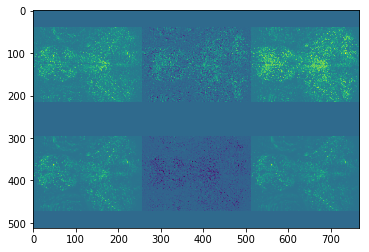

In [117]:
plt.imshow(frame)

In [72]:
mymin, mymax

(0.0, 1809.97119140625)

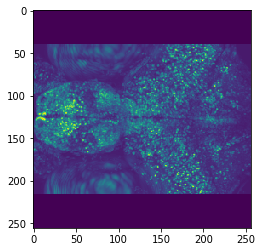

In [74]:
plt.imshow(scale_for_vid(mean_frame_T.numpy(), mymin, mymax))

In [31]:
del imaging